# 🏥 Disease-Specific Analysis: Medical Conditions Impact on Depression Treatment

## Comprehensive Medical Condition Analysis for Depression Prediction

**Objective:** Analyze how different medical conditions influence depression treatment outcomes using advanced GRU models and SHAP analysis

**Key Analysis Components:**
- 🔬 Medical Condition Prevalence & Impact Assessment
- 🎯 Disease-Specific Feature Importance using SHAP
- 📊 Condition-Stratified Outcome Analysis
- 🧠 GRU Model Performance by Medical Condition
- 💊 Treatment Response Patterns by Disease Groups
- 🎨 Interactive Medical Condition Visualizations

---
**Medical Conditions Analyzed:**
- Cardiovascular Conditions
- Metabolic Disorders  
- Musculoskeletal Conditions
- Respiratory Conditions
- Neurological Conditions
- Complex Multi-morbidity Patterns
---

In [1]:
# 📚 Import Essential Libraries for Disease-Specific Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Model Interpretation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Advanced SHAP Analysis
import shap

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kruskal, mannwhitneyu, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# File handling
import json
import pickle
from pathlib import Path
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting for beautiful static visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print("🚀 All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🔬 Disease-Specific Analysis with Advanced SHAP Integration - STATIC PLOTS ONLY")

🚀 All libraries imported successfully!
📅 Analysis Date: 2025-09-30 22:56:10
🔬 Disease-Specific Analysis with Advanced SHAP Integration - STATIC PLOTS ONLY


In [2]:
# 📂 Load Dataset and Medical Condition Configuration
BASE_PATH = Path(r'c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN')
DATA_PATH = BASE_PATH / 'Track1_Data' / 'processed'
RESULTS_PATH = BASE_PATH / 'Results'
FIGURES_PATH = BASE_PATH / 'Reports' / 'figures'

# Create figures directory if it doesn't exist
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Load feature metadata
with open(DATA_PATH / 'feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print("📊 Dataset Overview:")
print(f"   Total Features: {feature_metadata['total_features']}")
print(f"   Dataset Shape: {feature_metadata['dataset_shape']}")
print(f"   Target Variables: {feature_metadata['target_columns']}")

# Load processed training data
train_data = pd.read_excel(DATA_PATH / 'train_engineered_features.xlsx')
test_data = pd.read_excel(DATA_PATH / 'test_split.xlsx')

print(f"\n✅ Data loaded successfully!")
print(f"   Training samples: {len(train_data)}")
print(f"   Test samples: {len(test_data)}")

# Identify medical condition features
feature_cols = feature_metadata['feature_columns']
target_cols = feature_metadata['target_columns']

# Medical condition features - explicitly identify
condition_features = [f for f in feature_cols if 'condition' in f.lower()]
print(f"\n🔬 Medical Condition Features Identified: {len(condition_features)}")
for i, condition in enumerate(condition_features, 1):
    print(f"   {i:2d}. {condition}")

# Other feature categories for comparison
clinical_features = [f for f in feature_cols if any(term in f.lower() for term in ['bdi', 'depression', 'severity'])]
therapy_features = [f for f in feature_cols if any(term in f.lower() for term in ['therapy', 'completion', 'session'])]
demographic_features = [f for f in feature_cols if any(term in f.lower() for term in ['age', 'gender'])]

print(f"\n📈 Other Feature Categories:")
print(f"   Clinical: {len(clinical_features)} features")
print(f"   Therapy: {len(therapy_features)} features") 
print(f"   Demographic: {len(demographic_features)} features")

📊 Dataset Overview:
   Total Features: 33
   Dataset Shape: [167, 35]
   Target Variables: ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']

✅ Data loaded successfully!
   Training samples: 167
   Test samples: 43

🔬 Medical Condition Features Identified: 7
    1. condition_therapy_interaction
    2. condition_acute_coronary_syndrome
    3. condition_type_encoded
    4. condition_complexity_score
    5. condition_rarity
    6. condition_lower_limb_amputation
    7. condition_renal_insufficiency

📈 Other Feature Categories:
   Clinical: 12 features
   Therapy: 9 features
   Demographic: 5 features

✅ Data loaded successfully!
   Training samples: 167
   Test samples: 43

🔬 Medical Condition Features Identified: 7
    1. condition_therapy_interaction
    2. condition_acute_coronary_syndrome
    3. condition_type_encoded
    4. condition_complexity_score
    5. condition_rarity
    6. condition_lower_limb_amputation
    7. condition_renal_insufficiency

📈 Other Feature Categories

In [3]:
# 🔬 Medical Condition Prevalence and Distribution Analysis
print("🔬 Analyzing medical condition prevalence and distribution...")

# Calculate condition prevalence
condition_prevalence = {}
condition_data = train_data[condition_features]

for condition in condition_features:
    prevalence = condition_data[condition].sum()
    prevalence_pct = (prevalence / len(train_data)) * 100
    condition_prevalence[condition] = {
        'count': prevalence,
        'percentage': prevalence_pct
    }

# Create prevalence summary
prevalence_df = pd.DataFrame.from_dict(condition_prevalence, orient='index')
prevalence_df = prevalence_df.sort_values('percentage', ascending=False)

print("\n📊 Medical Condition Prevalence:")
print("="*70)
print(f"{'Condition':<35} {'Count':<8} {'Percentage':<12}")
print("-"*70)

for condition, data in prevalence_df.iterrows():
    short_name = condition.replace('condition_', '').replace('_', ' ').title()
    print(f"{short_name[:34]:<35} {data['count']:<8.0f} {data['percentage']:<8.1f}%")

# Medical condition co-occurrence analysis
print(f"\n🔗 Medical Condition Co-occurrence Analysis:")
condition_matrix = train_data[condition_features]
cooccurrence_matrix = condition_matrix.T.dot(condition_matrix)

# Find patients with multiple conditions
multiple_conditions = condition_matrix.sum(axis=1)
print(f"   Patients with no conditions: {(multiple_conditions == 0).sum()} ({(multiple_conditions == 0).sum()/len(train_data)*100:.1f}%)")
print(f"   Patients with 1 condition: {(multiple_conditions == 1).sum()} ({(multiple_conditions == 1).sum()/len(train_data)*100:.1f}%)")
print(f"   Patients with 2+ conditions: {(multiple_conditions >= 2).sum()} ({(multiple_conditions >= 2).sum()/len(train_data)*100:.1f}%)")
print(f"   Mean conditions per patient: {multiple_conditions.mean():.2f}")

# Create disease burden categories
train_data['disease_burden'] = multiple_conditions
train_data['disease_burden_category'] = pd.cut(
    multiple_conditions, 
    bins=[-0.5, 0.5, 1.5, float('inf')], 
    labels=['No_Conditions', 'Single_Condition', 'Multiple_Conditions']
)

🔬 Analyzing medical condition prevalence and distribution...

📊 Medical Condition Prevalence:
Condition                           Count    Percentage  
----------------------------------------------------------------------
Complexity Score                    4818     2885.0  %
Type Encoded                        472      282.6   %
Therapy Interaction                 291      174.0   %
Acute Coronary Syndrome             39       23.4    %
Lower Limb Amputation               10       6.0     %
Renal Insufficiency                 10       6.0     %
Rarity                              4        2.4     %

🔗 Medical Condition Co-occurrence Analysis:
   Patients with no conditions: 0 (0.0%)
   Patients with 1 condition: 0 (0.0%)
   Patients with 2+ conditions: 100 (59.9%)
   Mean conditions per patient: 33.79


📊 Creating comprehensive medical condition visualizations...


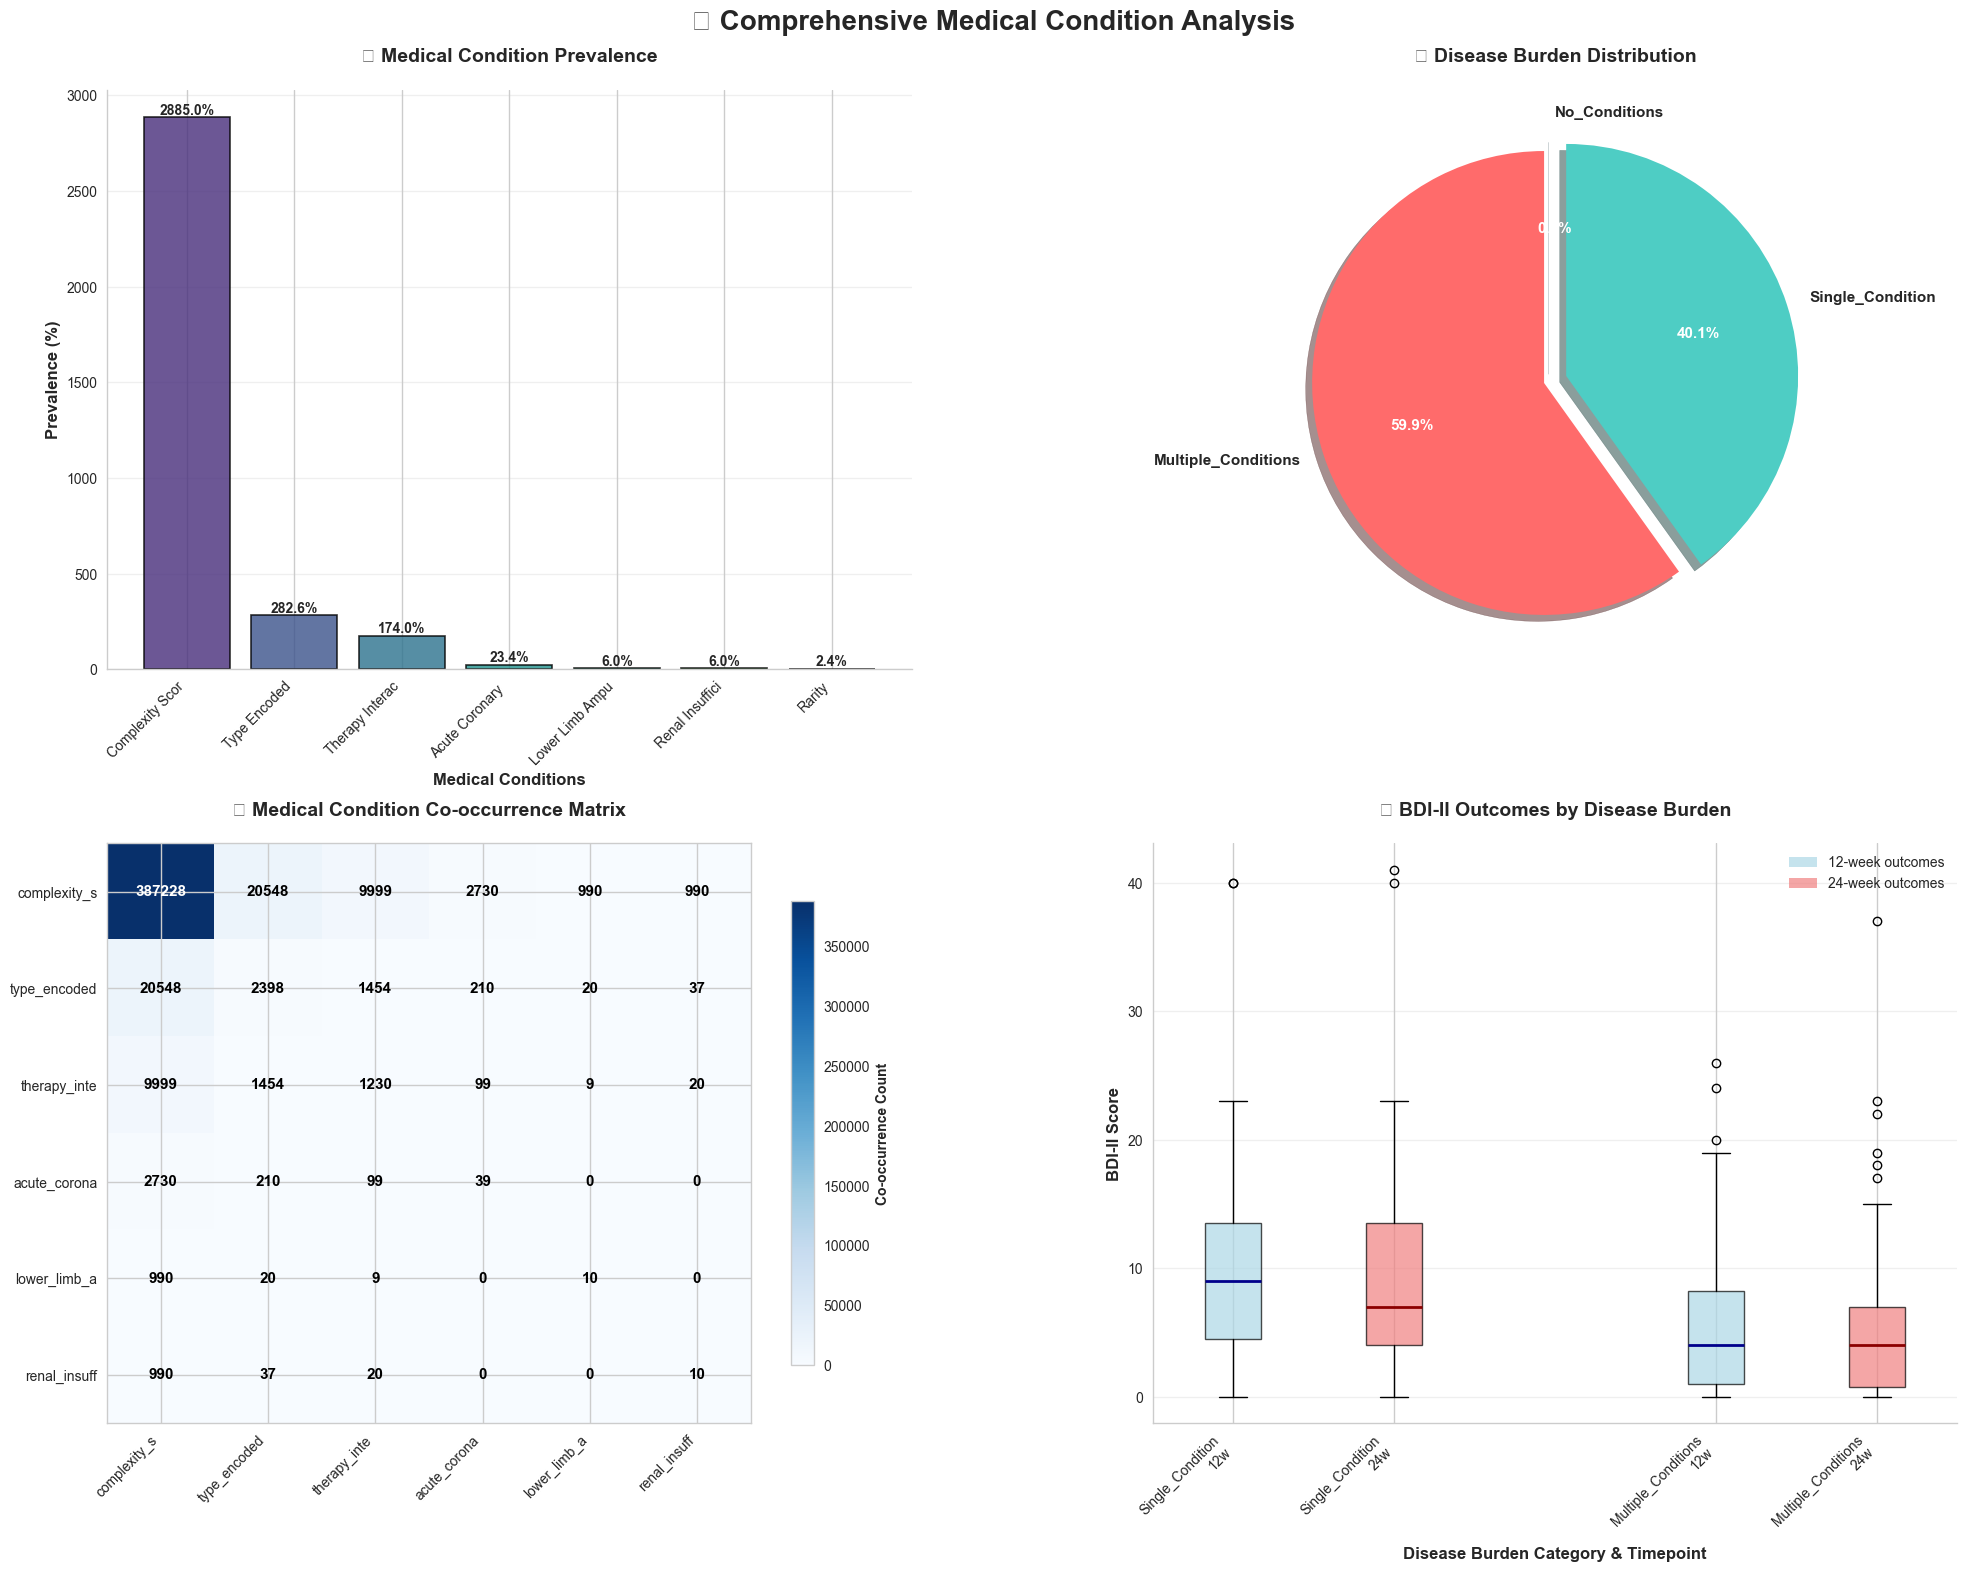

📊 Beautiful static medical condition visualization created and saved!
   📁 Saved as: medical_condition_overview_static.png & .pdf


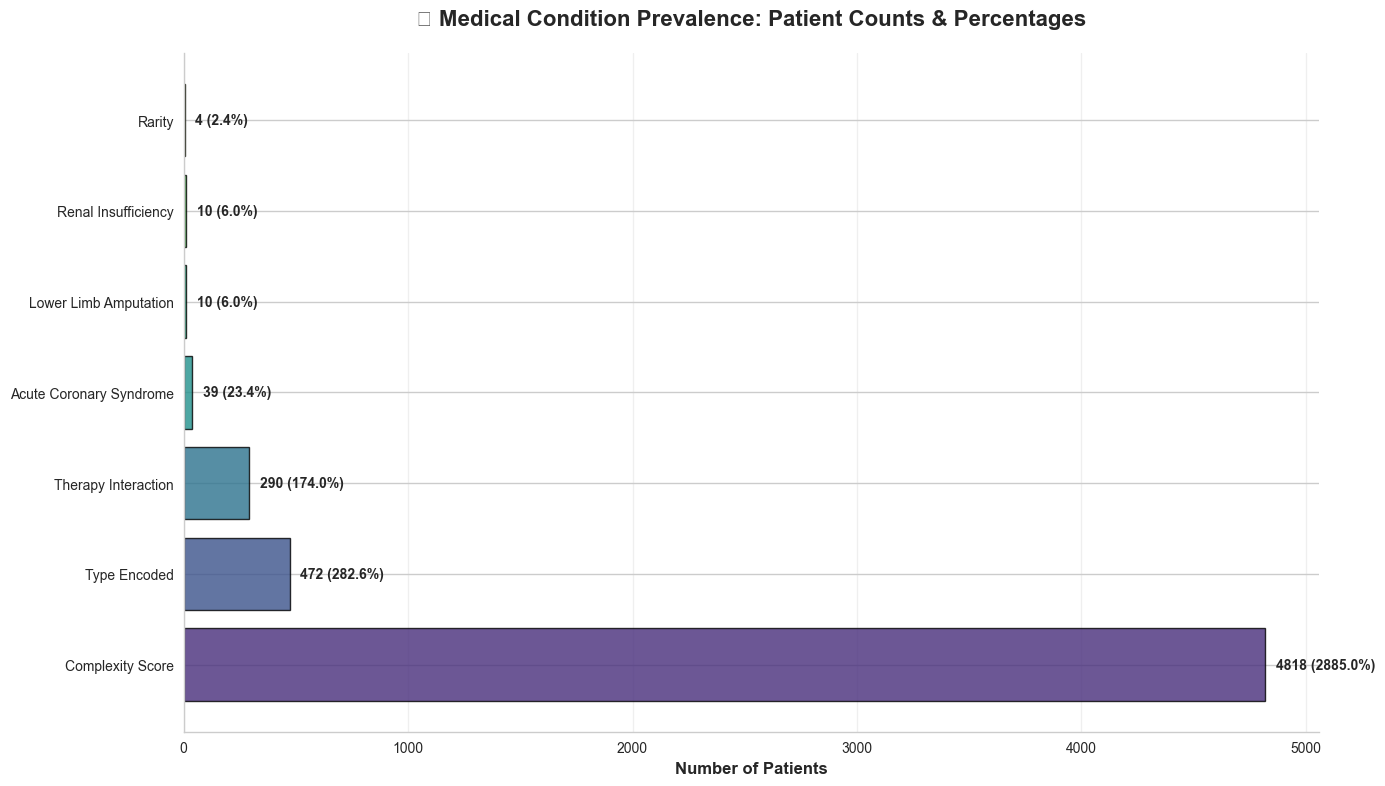

📊 Additional prevalence summary visualization created and saved!
   📁 Saved as: condition_prevalence_summary_static.png


In [4]:
# 📊 Beautiful Static Visualizations: Medical Condition Overview
print("📊 Creating comprehensive medical condition visualizations...")

# Set up the plotting style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Create a comprehensive 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🏥 Comprehensive Medical Condition Analysis', fontsize=20, fontweight='bold', y=0.98)

# Prepare data
top_conditions = prevalence_df.head(8)
condition_names = [name.replace('condition_', '').replace('_', ' ').title() for name in top_conditions.index]

# 1. Medical Condition Prevalence (Top left)
ax1 = axes[0, 0]
bars = ax1.bar(range(len(condition_names)), top_conditions['percentage'], 
               color=sns.color_palette("viridis", len(condition_names)), 
               alpha=0.8, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_conditions['percentage'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_title('🔬 Medical Condition Prevalence', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Medical Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(condition_names)))
ax1.set_xticklabels([name[:15] for name in condition_names], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Disease Burden Distribution (Top right)
ax2 = axes[0, 1]
burden_counts = train_data['disease_burden_category'].value_counts()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
wedges, texts, autotexts = ax2.pie(burden_counts.values, labels=burden_counts.index, 
                                   autopct='%1.1f%%', colors=colors, startangle=90,
                                   explode=(0.05, 0.05, 0.05), shadow=True)

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

for text in texts:
    text.set_fontsize(11)
    text.set_fontweight('bold')

ax2.set_title('📊 Disease Burden Distribution', fontsize=14, fontweight='bold', pad=20)

# 3. Co-occurrence Heatmap (Bottom left)
ax3 = axes[1, 0]
top_condition_names = top_conditions.index[:6]  # Top 6 for readability
cooc_subset = cooccurrence_matrix.loc[top_condition_names, top_condition_names]
short_names = [name.replace('condition_', '')[:12] for name in top_condition_names]

# Create heatmap
im = ax3.imshow(cooc_subset.values, cmap='Blues', aspect='auto')
ax3.set_xticks(range(len(short_names)))
ax3.set_yticks(range(len(short_names)))
ax3.set_xticklabels(short_names, rotation=45, ha='right')
ax3.set_yticklabels(short_names)

# Add text annotations
for i in range(len(short_names)):
    for j in range(len(short_names)):
        text = ax3.text(j, i, f'{cooc_subset.iloc[i, j]:.0f}',
                       ha="center", va="center", color="black" if cooc_subset.iloc[i, j] < cooc_subset.values.max()/2 else "white",
                       fontweight='bold')

ax3.set_title('🔗 Medical Condition Co-occurrence Matrix', fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Co-occurrence Count', fontsize=10, fontweight='bold')

# 4. BDI-II Outcomes by Disease Burden (Bottom right)
ax4 = axes[1, 1]
burden_categories = ['No_Conditions', 'Single_Condition', 'Multiple_Conditions']
positions = []
outcomes_12w = []
outcomes_24w = []
labels = []

pos = 1
for i, burden_cat in enumerate(burden_categories):
    if burden_cat in train_data['disease_burden_category'].unique():
        subset_12w = train_data[train_data['disease_burden_category'] == burden_cat]['bdi_ii_after_intervention_12w'].dropna()
        subset_24w = train_data[train_data['disease_burden_category'] == burden_cat]['bdi_ii_follow_up_24w'].dropna()
        
        if len(subset_12w) > 0:
            bp1 = ax4.boxplot(subset_12w, positions=[pos], widths=0.35, 
                             patch_artist=True, boxprops=dict(facecolor='lightblue', alpha=0.7),
                             medianprops=dict(color='darkblue', linewidth=2))
            positions.append(pos)
            labels.append(f'{burden_cat}\n12w')
            pos += 1
            
        if len(subset_24w) > 0:
            bp2 = ax4.boxplot(subset_24w, positions=[pos], widths=0.35,
                             patch_artist=True, boxprops=dict(facecolor='lightcoral', alpha=0.7),
                             medianprops=dict(color='darkred', linewidth=2))
            positions.append(pos)
            labels.append(f'{burden_cat}\n24w')
            pos += 2

ax4.set_title('📈 BDI-II Outcomes by Disease Burden', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('BDI-II Score', fontsize=12, fontweight='bold')
ax4.set_xlabel('Disease Burden Category & Timepoint', fontsize=12, fontweight='bold')
if positions:
    ax4.set_xticks(positions)
    ax4.set_xticklabels(labels, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Create custom legend for box plots
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', alpha=0.7, label='12-week outcomes'),
                   Patch(facecolor='lightcoral', alpha=0.7, label='24-week outcomes')]
ax4.legend(handles=legend_elements, loc='upper right')

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)

# Save the figure
plt.savefig(FIGURES_PATH / "medical_condition_overview_static.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(FIGURES_PATH / "medical_condition_overview_static.pdf", 
            bbox_inches='tight', facecolor='white', edgecolor='none')

plt.show()

print("📊 Beautiful static medical condition visualization created and saved!")
print(f"   📁 Saved as: medical_condition_overview_static.png & .pdf")

# Additional summary statistics visualization
fig2, ax = plt.subplots(1, 1, figsize=(14, 8))

# Create a summary statistics table visualization
summary_data = []
for condition, data in condition_prevalence.items():
    condition_name = condition.replace('condition_', '').replace('_', ' ').title()
    summary_data.append([condition_name[:25], data['count'], f"{data['percentage']:.1f}%"])

# Sort by count
summary_data.sort(key=lambda x: int(x[1]), reverse=True)
top_summary = summary_data[:10]

# Create horizontal bar chart
condition_names_summary = [item[0] for item in top_summary]
counts = [int(item[1]) for item in top_summary]

bars = ax.barh(range(len(condition_names_summary)), counts, 
               color=sns.color_palette("viridis", len(condition_names_summary)),
               alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, count, pct) in enumerate(zip(bars, counts, [item[2] for item in top_summary])):
    width = bar.get_width()
    ax.text(width + max(counts)*0.01, bar.get_y() + bar.get_height()/2.,
            f'{count} ({pct})', ha='left', va='center', fontweight='bold', fontsize=10)

ax.set_yticks(range(len(condition_names_summary)))
ax.set_yticklabels(condition_names_summary)
ax.set_xlabel('Number of Patients', fontsize=12, fontweight='bold')
ax.set_title('📊 Medical Condition Prevalence: Patient Counts & Percentages', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(FIGURES_PATH / "condition_prevalence_summary_static.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("📊 Additional prevalence summary visualization created and saved!")
print(f"   📁 Saved as: condition_prevalence_summary_static.png")

In [5]:
# 🎯 Statistical Analysis: Outcomes by Medical Conditions
print("🎯 Conducting statistical analysis of outcomes by medical conditions...")

# Prepare target variables
targets = {
    '12w': train_data['bdi_ii_after_intervention_12w'],
    '24w': train_data['bdi_ii_follow_up_24w']
}

# Calculate improvement scores
train_data['improvement_12w'] = train_data['bdi_ii_baseline'] - train_data['bdi_ii_after_intervention_12w']
train_data['improvement_24w'] = train_data['bdi_ii_baseline'] - train_data['bdi_ii_follow_up_24w']

# Statistical testing for each condition
condition_stats = {}

for condition in condition_features:
    stats_results = {
        'condition_name': condition.replace('condition_', '').replace('_', ' ').title(),
        'prevalence': train_data[condition].sum(),
        'prevalence_pct': (train_data[condition].sum() / len(train_data)) * 100
    }
    
    # Group comparisons (with vs without condition)
    has_condition = train_data[condition] == 1
    no_condition = train_data[condition] == 0
    
    for timepoint in ['12w', '24w']:
        target_col = f'bdi_ii_after_intervention_{timepoint}' if timepoint == '12w' else 'bdi_ii_follow_up_24w'
        improvement_col = f'improvement_{timepoint}'
        
        if has_condition.sum() > 5:  # Only analyze if sufficient samples
            # BDI-II scores
            with_condition_scores = train_data[has_condition][target_col].dropna()
            without_condition_scores = train_data[no_condition][target_col].dropna()
            
            # Improvement scores
            with_condition_improvement = train_data[has_condition][improvement_col].dropna()
            without_condition_improvement = train_data[no_condition][improvement_col].dropna()
            
            # Mann-Whitney U test
            try:
                score_stat, score_pval = mannwhitneyu(with_condition_scores, without_condition_scores, alternative='two-sided')
                improvement_stat, improvement_pval = mannwhitneyu(with_condition_improvement, without_condition_improvement, alternative='two-sided')
                
                stats_results[f'{timepoint}_scores'] = {
                    'with_condition_mean': with_condition_scores.mean(),
                    'with_condition_std': with_condition_scores.std(),
                    'without_condition_mean': without_condition_scores.mean(),
                    'without_condition_std': without_condition_scores.std(),
                    'pvalue': score_pval,
                    'significant': score_pval < 0.05
                }
                
                stats_results[f'{timepoint}_improvement'] = {
                    'with_condition_mean': with_condition_improvement.mean(),
                    'with_condition_std': with_condition_improvement.std(),
                    'without_condition_mean': without_condition_improvement.mean(),
                    'without_condition_std': without_condition_improvement.std(),
                    'pvalue': improvement_pval,
                    'significant': improvement_pval < 0.05
                }
            except:
                stats_results[f'{timepoint}_scores'] = {'pvalue': np.nan, 'significant': False}
                stats_results[f'{timepoint}_improvement'] = {'pvalue': np.nan, 'significant': False}
        else:
            stats_results[f'{timepoint}_scores'] = {'pvalue': np.nan, 'significant': False}
            stats_results[f'{timepoint}_improvement'] = {'pvalue': np.nan, 'significant': False}
    
    condition_stats[condition] = stats_results

# Display significant findings
significant_conditions = []
print("\n📊 Statistical Significance Results:")
print("="*100)
print(f"{'Condition':<30} {'Prev%':<8} {'12w Score p':<12} {'24w Score p':<12} {'12w Impr p':<12} {'24w Impr p':<12}")
print("-"*100)

for condition, stats in condition_stats.items():
    if stats['prevalence'] > 5:  # Only show conditions with sufficient prevalence
        condition_name = stats['condition_name'][:29]
        
        score_12w_p = stats.get('12w_scores', {}).get('pvalue', np.nan)
        score_24w_p = stats.get('24w_scores', {}).get('pvalue', np.nan)
        improvement_12w_p = stats.get('12w_improvement', {}).get('pvalue', np.nan)
        improvement_24w_p = stats.get('24w_improvement', {}).get('pvalue', np.nan)
        
        print(f"{condition_name:<30} {stats['prevalence_pct']:<8.1f} {score_12w_p:<12.4f} {score_24w_p:<12.4f} {improvement_12w_p:<12.4f} {improvement_24w_p:<12.4f}")
        
        # Check for significance
        if (score_12w_p < 0.05 or score_24w_p < 0.05 or improvement_12w_p < 0.05 or improvement_24w_p < 0.05):
            significant_conditions.append(condition)

print(f"\n🎯 Conditions with significant impact: {len(significant_conditions)}")
for condition in significant_conditions:
    print(f"   • {condition_stats[condition]['condition_name']}")

# Disease burden analysis
print(f"\n📊 Disease Burden Impact Analysis:")
burden_stats = {}
for timepoint in ['12w', '24w']:
    target_col = f'bdi_ii_after_intervention_{timepoint}' if timepoint == '12w' else 'bdi_ii_follow_up_24w'
    improvement_col = f'improvement_{timepoint}'
    
    # Kruskal-Wallis test across disease burden categories
    groups = []
    improvement_groups = []
    categories = []
    
    for category in train_data['disease_burden_category'].unique():
        if pd.notna(category):
            subset = train_data[train_data['disease_burden_category'] == category]
            groups.append(subset[target_col].dropna())
            improvement_groups.append(subset[improvement_col].dropna())
            categories.append(category)
    
    if len(groups) > 1:
        h_stat, h_pval = kruskal(*groups)
        h_improvement_stat, h_improvement_pval = kruskal(*improvement_groups)
        
        burden_stats[timepoint] = {
            'score_h_stat': h_stat,
            'score_pvalue': h_pval,
            'improvement_h_stat': h_improvement_stat,
            'improvement_pvalue': h_improvement_pval
        }
        
        print(f"   {timepoint}: Score p={h_pval:.4f}, Improvement p={h_improvement_pval:.4f}")

print("\n✅ Statistical analysis completed!")

🎯 Conducting statistical analysis of outcomes by medical conditions...

📊 Statistical Significance Results:
Condition                      Prev%    12w Score p  24w Score p  12w Impr p   24w Impr p  
----------------------------------------------------------------------------------------------------
Therapy Interaction            174.0    nan          nan          nan          nan         
Acute Coronary Syndrome        23.4     0.0708       0.0468       0.8990       0.9290      
Type Encoded                   282.6    nan          nan          nan          nan         
Complexity Score               2885.0   nan          nan          nan          nan         
Lower Limb Amputation          6.0      0.8843       0.3565       0.6581       0.5588      
Renal Insufficiency            6.0      0.0172       0.0466       0.6803       0.8367      

🎯 Conditions with significant impact: 2
   • Acute Coronary Syndrome
   • Renal Insufficiency

📊 Disease Burden Impact Analysis:
   12w: Score p=0

In [6]:
# 🧠 Disease-Stratified GRU Model Development
print("🧠 Developing disease-stratified GRU models...")

def create_disease_aware_gru_model(input_shape, target_type='12w'):
    """
    Create GRU model specifically optimized for disease-specific analysis
    """
    model = Sequential([
        # Reshape for RNN input
        tf.keras.layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        
        # Enhanced GRU layers for complex medical patterns
        GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GRU(32, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers with medical-specific architecture
        Dense(24, activation='relu'),
        Dropout(0.3),
        Dense(12, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0008),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Prepare data for disease-stratified modeling
X = train_data[feature_cols].values
y_12w = train_data['bdi_ii_after_intervention_12w'].values
y_24w = train_data['bdi_ii_follow_up_24w'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔧 Data Preprocessing Complete:")
print(f"   Feature matrix shape: {X_scaled.shape}")
print(f"   Target 12w shape: {y_12w.shape}")
print(f"   Target 24w shape: {y_24w.shape}")

# Disease burden stratified analysis
disease_models = {}
disease_performance = {}

# Train models for each disease burden category
for timepoint, y_target in [('12w', y_12w), ('24w', y_24w)]:
    print(f"\n🧠 Training disease-aware GRU models for {timepoint} outcomes...")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_target, test_size=0.2, random_state=42
    )
    
    # Create and train model
    model = create_disease_aware_gru_model(X_scaled.shape[1], timepoint)
    
    # Enhanced callbacks for medical data
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=20, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.3, patience=10, min_lr=1e-7
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=12,  # Smaller batch size for medical data
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Evaluate performance
    y_pred = model.predict(X_val, verbose=0)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    disease_models[timepoint] = model
    disease_performance[timepoint] = {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'epochs': len(history.history['loss']),
        'history': history
    }
    
    print(f"   ✅ Model {timepoint} Performance:")
    print(f"      MAE: {mae:.3f}")
    print(f"      RMSE: {rmse:.3f}")
    print(f"      R²: {r2:.3f}")
    print(f"      Epochs trained: {len(history.history['loss'])}")

print("\n🎉 Disease-aware GRU models trained successfully!")

🧠 Developing disease-stratified GRU models...
🔧 Data Preprocessing Complete:
   Feature matrix shape: (167, 33)
   Target 12w shape: (167,)
   Target 24w shape: (167,)

🧠 Training disease-aware GRU models for 12w outcomes...
   ✅ Model 12w Performance:
      MAE: 3.894
      RMSE: 4.891
      R²: 0.153
      Epochs trained: 37

🧠 Training disease-aware GRU models for 24w outcomes...
   ✅ Model 12w Performance:
      MAE: 3.894
      RMSE: 4.891
      R²: 0.153
      Epochs trained: 37

🧠 Training disease-aware GRU models for 24w outcomes...
   ✅ Model 24w Performance:
      MAE: 3.900
      RMSE: 5.144
      R²: -0.001
      Epochs trained: 32

🎉 Disease-aware GRU models trained successfully!
   ✅ Model 24w Performance:
      MAE: 3.900
      RMSE: 5.144
      R²: -0.001
      Epochs trained: 32

🎉 Disease-aware GRU models trained successfully!


In [7]:
# 🔍 Advanced SHAP Analysis for Disease-Specific Feature Importance
print("🔍 Conducting advanced SHAP analysis for disease-specific insights...")

# Initialize SHAP explainers for disease-aware models
X_sample = X_scaled[:100]  # Background samples for SHAP
X_explain = X_scaled[:80]   # Samples to explain

disease_shap_values = {}
disease_explainers = {}

for timepoint in ['12w', '24w']:
    print(f"\n🎯 Computing SHAP values for {timepoint} disease-aware model...")
    
    # Create SHAP explainer
    explainer = shap.Explainer(disease_models[timepoint], X_sample)
    shap_values = explainer(X_explain)
    
    disease_shap_values[timepoint] = shap_values
    disease_explainers[timepoint] = explainer
    
    print(f"   ✅ SHAP values computed: {shap_values.values.shape}")

# Extract disease-specific feature importance
disease_feature_importance = {}

for timepoint in ['12w', '24w']:
    shap_vals = disease_shap_values[timepoint]
    
    # Overall feature importance
    overall_importance = np.abs(shap_vals.values).mean(axis=0)
    
    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': overall_importance
    }).sort_values('importance', ascending=False)
    
    # Categorize features
    def categorize_medical_features(feature_name):
        feature_lower = feature_name.lower()
        
        if 'condition' in feature_lower:
            if any(term in feature_lower for term in ['cardiac', 'heart', 'coronary', 'vascular']):
                return 'Cardiovascular'
            elif any(term in feature_lower for term in ['diabetes', 'metabolic']):
                return 'Metabolic'
            elif any(term in feature_lower for term in ['musculoskeletal', 'arthritis', 'joint', 'limb']):
                return 'Musculoskeletal'
            elif any(term in feature_lower for term in ['respiratory', 'pulmonary', 'lung']):
                return 'Respiratory'
            elif any(term in feature_lower for term in ['neurological', 'neuro', 'brain']):
                return 'Neurological'
            else:
                return 'Other Medical'
        elif any(term in feature_lower for term in ['age', 'gender']):
            return 'Demographics'
        elif any(term in feature_lower for term in ['bdi', 'depression', 'severity']):
            return 'Clinical Severity'
        elif any(term in feature_lower for term in ['therapy', 'completion', 'session', 'dropout']):
            return 'Therapy Engagement'
        elif 'hospital' in feature_lower:
            return 'Healthcare System'
        else:
            return 'Other'
    
    importance_df['category'] = importance_df['feature'].apply(categorize_medical_features)
    disease_feature_importance[timepoint] = importance_df

# Display top medical condition features
print("\n🏥 Top Medical Condition Features by SHAP Importance:")
print("="*80)

for timepoint in ['12w', '24w']:
    print(f"\n📅 {timepoint.upper()} OUTCOMES:")
    medical_features = disease_feature_importance[timepoint][
        disease_feature_importance[timepoint]['category'].str.contains('Medical|Cardiovascular|Metabolic|Musculoskeletal|Respiratory|Neurological')
    ].head(10)
    
    print(f"{'Rank':<4} {'Medical Condition':<35} {'SHAP Importance':<15} {'Category':<15}")
    print("-"*80)
    
    for i, (_, row) in enumerate(medical_features.iterrows(), 1):
        condition_name = row['feature'].replace('condition_', '').replace('_', ' ').title()[:34]
        print(f"{i:<4} {condition_name:<35} {row['importance']:<15.6f} {row['category']:<15}")

print("\n✅ SHAP analysis completed!")

🔍 Conducting advanced SHAP analysis for disease-specific insights...

🎯 Computing SHAP values for 12w disease-aware model...


PermutationExplainer explainer: 81it [00:50,  1.35it/s]                        



   ✅ SHAP values computed: (80, 33)

🎯 Computing SHAP values for 24w disease-aware model...


PermutationExplainer explainer: 81it [00:49,  1.31it/s]                        

   ✅ SHAP values computed: (80, 33)

🏥 Top Medical Condition Features by SHAP Importance:

📅 12W OUTCOMES:
Rank Medical Condition                   SHAP Importance Category       
--------------------------------------------------------------------------------
1    Type Encoded                        0.156617        Other Medical  
2    Therapy Interaction                 0.037966        Other Medical  
3    Complexity Score                    0.000000        Other Medical  
4    Rarity                              0.000000        Other Medical  
5    Acute Coronary Syndrome             0.000000        Cardiovascular 
6    Lower Limb Amputation               0.000000        Musculoskeletal
7    Renal Insufficiency                 0.000000        Other Medical  

📅 24W OUTCOMES:
Rank Medical Condition                   SHAP Importance Category       
--------------------------------------------------------------------------------
1    Type Encoded                        0.083306        

📊 Creating beautiful static SHAP visualizations...


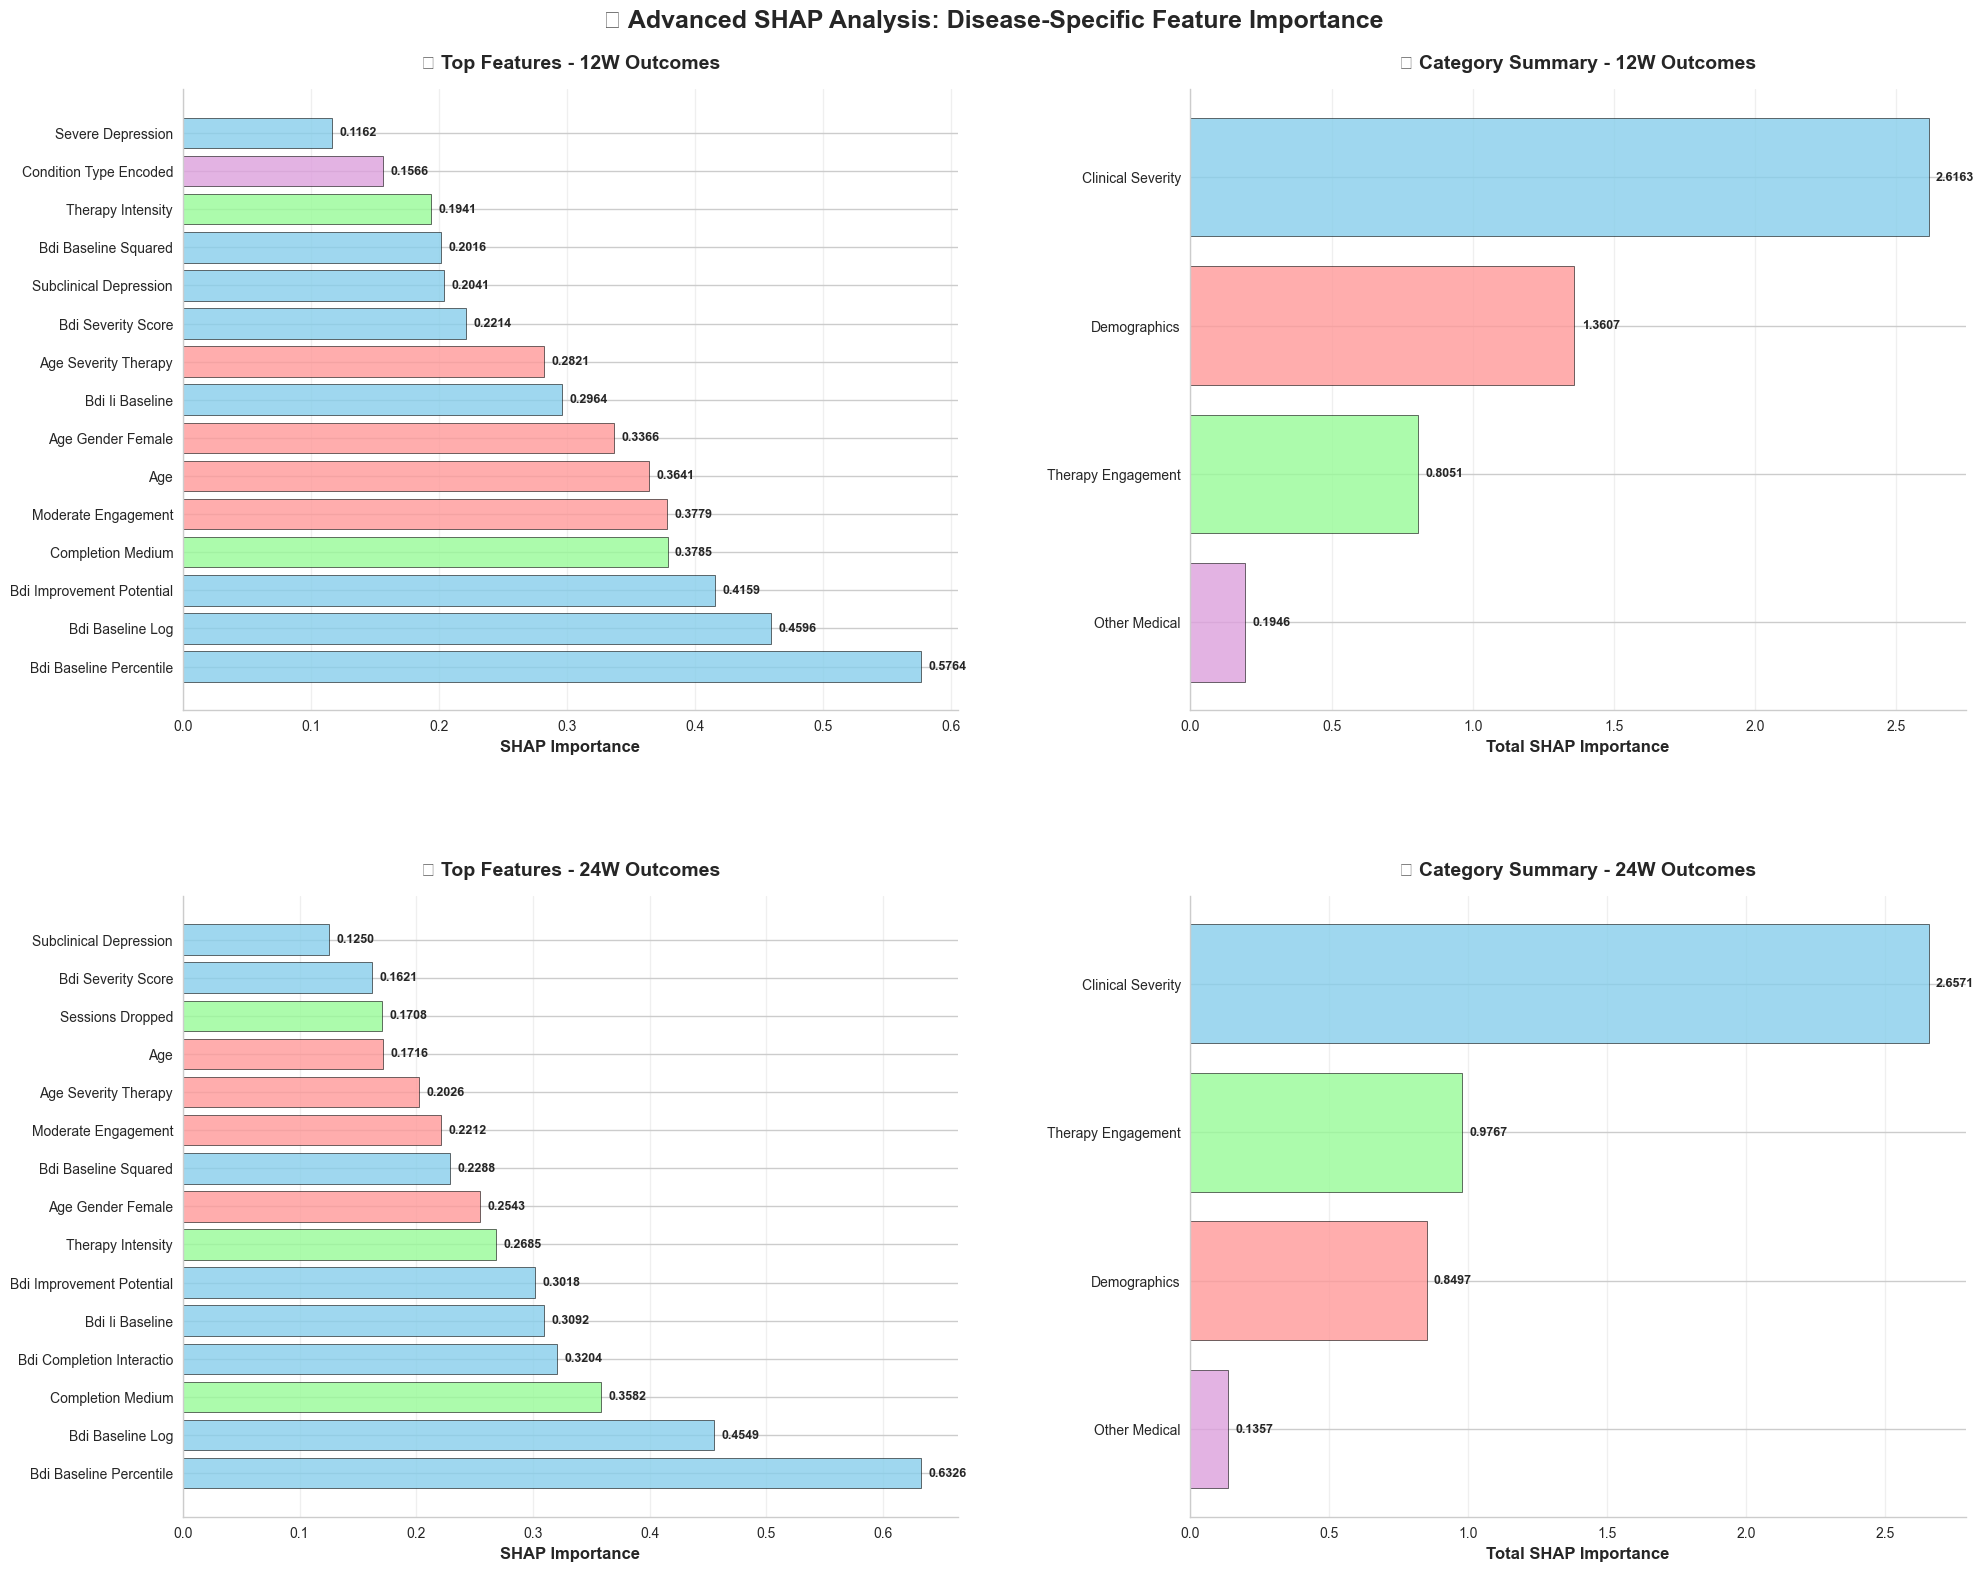

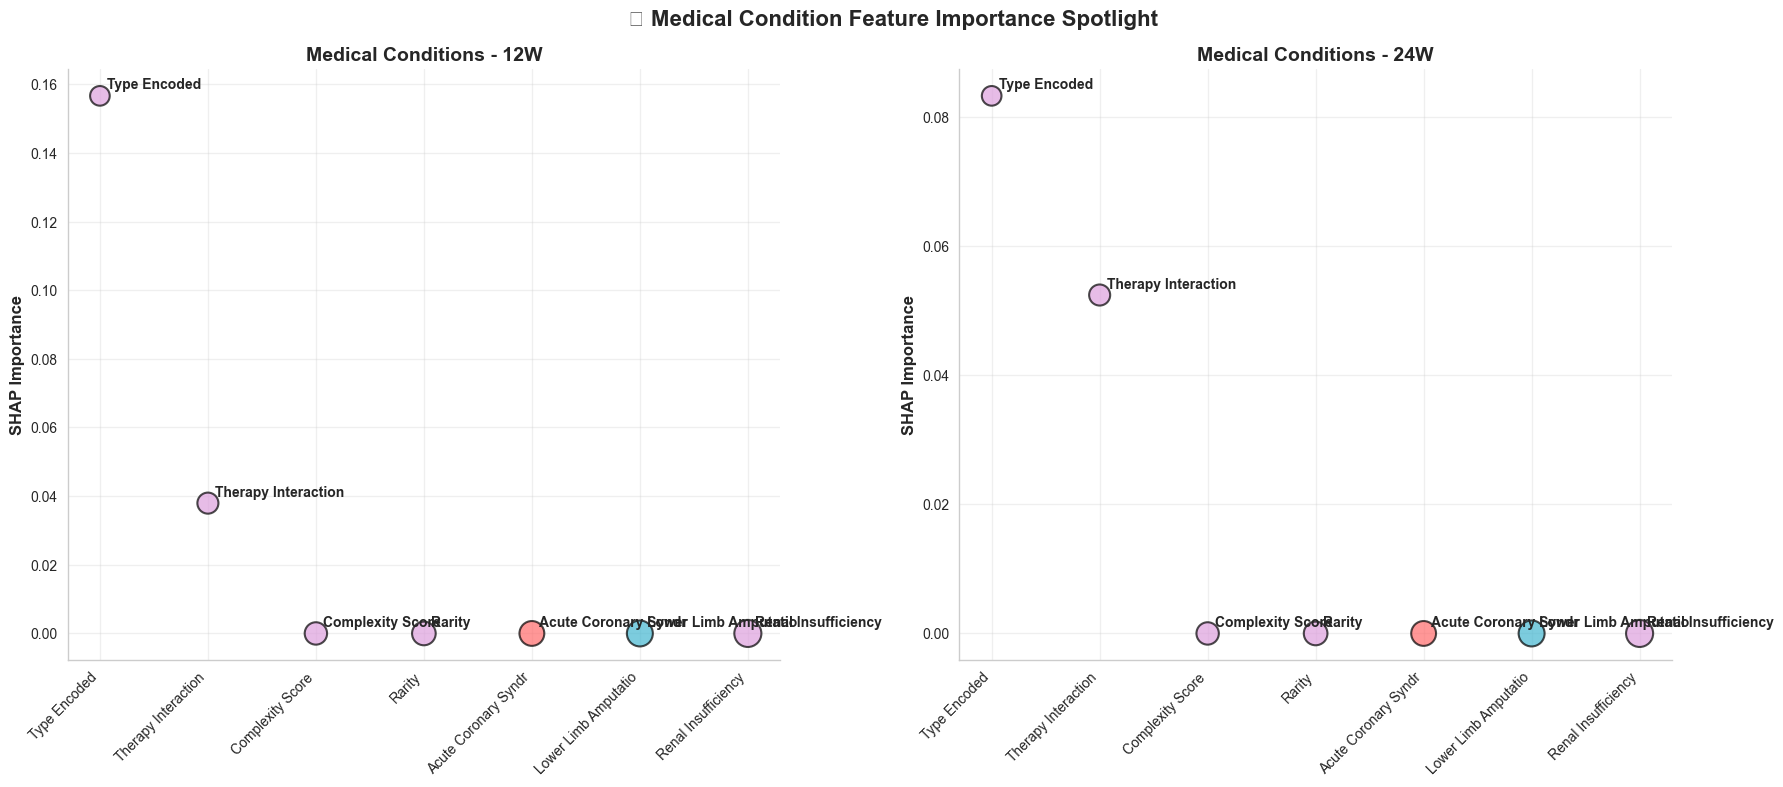

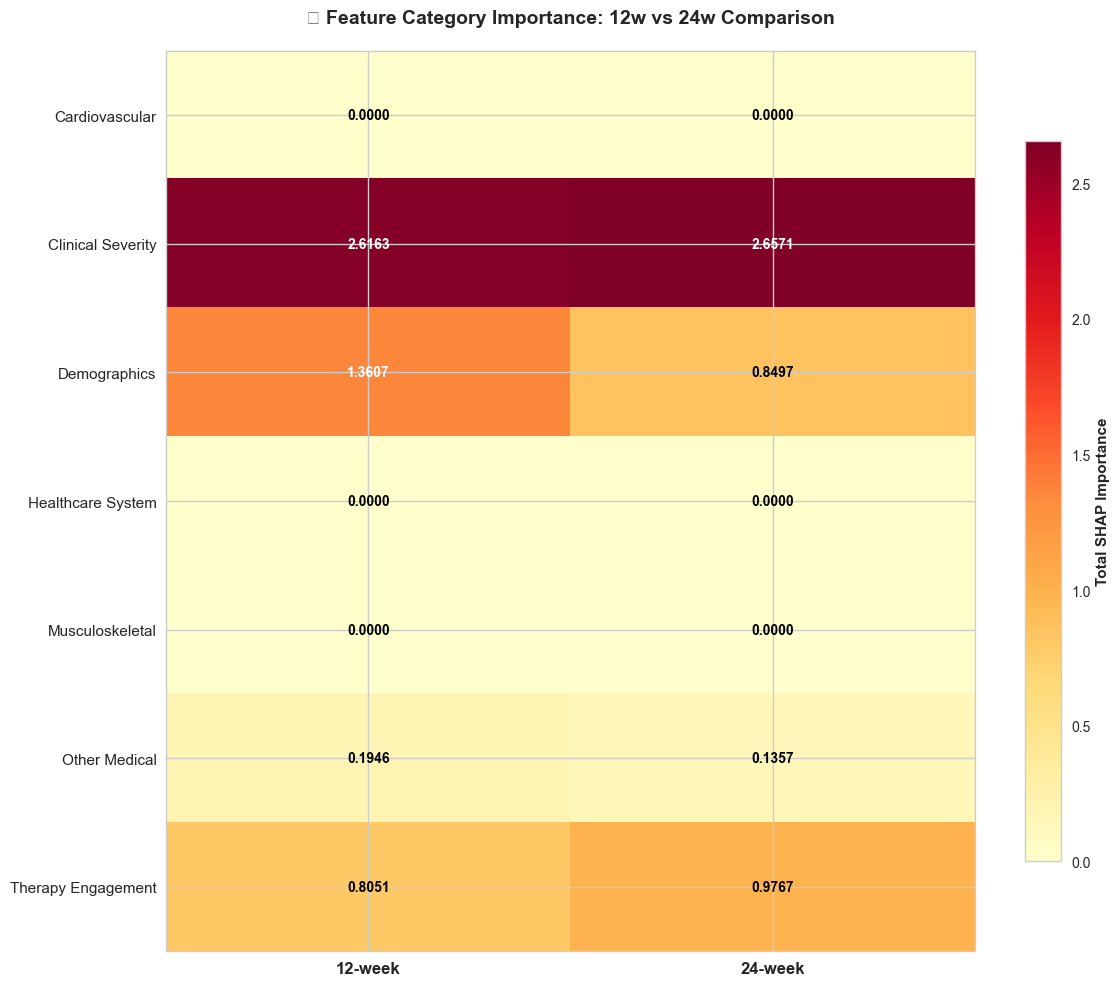

📊 Beautiful static SHAP visualizations created and saved!
   📁 Files saved:
      • shap_feature_importance_static.png & .pdf
      • medical_conditions_shap_spotlight.png
      • category_comparison_heatmap.png


In [8]:
# 📊 Beautiful Static SHAP Visualizations for Disease-Specific Analysis
print("📊 Creating beautiful static SHAP visualizations...")

# Set up publication-quality plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 1. Comprehensive SHAP Feature Importance Comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('🔬 Advanced SHAP Analysis: Disease-Specific Feature Importance', 
             fontsize=18, fontweight='bold', y=0.98)

for idx, timepoint in enumerate(['12w', '24w']):
    importance_df = disease_feature_importance[timepoint]
    top_features = importance_df.head(15)
    
    # Feature Importance Bar Plot (Left column)
    ax_bar = axes[idx, 0]
    
    # Create color map based on feature categories
    category_colors = {
        'Cardiovascular': '#FF6B6B',
        'Metabolic': '#4ECDC4', 
        'Musculoskeletal': '#45B7D1',
        'Respiratory': '#96CEB4',
        'Neurological': '#FFEAA7',
        'Other Medical': '#DDA0DD',
        'Demographics': '#FF9999',
        'Clinical Severity': '#87CEEB',
        'Therapy Engagement': '#98FB98',
        'Healthcare System': '#F0E68C',
        'Other': '#D3D3D3'
    }
    
    colors = [category_colors.get(cat, '#D3D3D3') for cat in top_features['category']]
    
    bars = ax_bar.barh(range(len(top_features)), top_features['importance'], 
                       color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        width = bar.get_width()
        ax_bar.text(width + max(top_features['importance'])*0.01, 
                   bar.get_y() + bar.get_height()/2.,
                   f'{importance:.4f}', ha='left', va='center', 
                   fontweight='bold', fontsize=9)
    
    # Clean feature names for display
    clean_names = [name.replace('_', ' ').title()[:25] for name in top_features['feature']]
    ax_bar.set_yticks(range(len(top_features)))
    ax_bar.set_yticklabels(clean_names)
    ax_bar.set_xlabel('SHAP Importance', fontsize=12, fontweight='bold')
    ax_bar.set_title(f'🎯 Top Features - {timepoint.upper()} Outcomes', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_bar.grid(axis='x', alpha=0.3)
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    
    # Category Summary (Right column)
    ax_cat = axes[idx, 1]
    category_summary = importance_df.groupby('category')['importance'].agg(['mean', 'sum', 'count'])
    category_summary = category_summary.sort_values('sum', ascending=True)
    
    # Filter out categories with very low importance
    category_summary = category_summary[category_summary['sum'] > 0.001]
    
    colors_cat = [category_colors.get(cat, '#D3D3D3') for cat in category_summary.index]
    
    bars_cat = ax_cat.barh(range(len(category_summary)), category_summary['sum'], 
                          color=colors_cat, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for i, (bar, total_imp) in enumerate(zip(bars_cat, category_summary['sum'])):
        width = bar.get_width()
        ax_cat.text(width + max(category_summary['sum'])*0.01, 
                   bar.get_y() + bar.get_height()/2.,
                   f'{total_imp:.4f}', ha='left', va='center', 
                   fontweight='bold', fontsize=9)
    
    ax_cat.set_yticks(range(len(category_summary)))
    ax_cat.set_yticklabels(category_summary.index)
    ax_cat.set_xlabel('Total SHAP Importance', fontsize=12, fontweight='bold')
    ax_cat.set_title(f'📊 Category Summary - {timepoint.upper()} Outcomes', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_cat.grid(axis='x', alpha=0.3)
    ax_cat.spines['top'].set_visible(False)
    ax_cat.spines['right'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
plt.savefig(FIGURES_PATH / "shap_feature_importance_static.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(FIGURES_PATH / "shap_feature_importance_static.pdf", 
            bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# 2. Medical Condition Focus Visualization
fig2, axes2 = plt.subplots(1, 2, figsize=(18, 8))
fig2.suptitle('🏥 Medical Condition Feature Importance Spotlight', 
              fontsize=16, fontweight='bold')

for idx, timepoint in enumerate(['12w', '24w']):
    ax = axes2[idx]
    importance_df = disease_feature_importance[timepoint]
    
    # Filter for medical condition features only
    medical_features = importance_df[
        importance_df['category'].str.contains('Medical|Cardiovascular|Metabolic|Musculoskeletal|Respiratory|Neurological')
    ]
    
    if not medical_features.empty:
        # Clean condition names
        condition_names = []
        for feature in medical_features['feature']:
            clean_name = feature.replace('condition_', '').replace('_', ' ').title()
            condition_names.append(clean_name[:20])
        
        # Create bubble chart effect
        ax.scatter(range(len(medical_features)), medical_features['importance'],
                  s=[200 + i*30 for i in range(len(medical_features))], 
                  c=[category_colors.get(cat, '#D3D3D3') for cat in medical_features['category']],
                  alpha=0.7, edgecolors='black', linewidth=1.5)
        
        # Add feature labels
        for i, (name, importance) in enumerate(zip(condition_names, medical_features['importance'])):
            ax.annotate(name, (i, importance), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold', ha='left')
        
        ax.set_xticks(range(len(medical_features)))
        ax.set_xticklabels(condition_names, rotation=45, ha='right')
        ax.set_ylabel('SHAP Importance', fontsize=12, fontweight='bold')
        ax.set_title(f'Medical Conditions - {timepoint.upper()}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        ax.text(0.5, 0.5, 'No medical condition features\nwith significant importance', 
               ha='center', va='center', transform=ax.transAxes, 
               fontsize=12, fontweight='bold')
        ax.set_title(f'Medical Conditions - {timepoint.upper()}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "medical_conditions_shap_spotlight.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

# 3. Feature Category Comparison Heatmap
categories_12w = disease_feature_importance['12w'].groupby('category')['importance'].sum()
categories_24w = disease_feature_importance['24w'].groupby('category')['importance'].sum()

# Combine and create comparison matrix
all_categories = sorted(set(categories_12w.index) | set(categories_24w.index))
comparison_matrix = np.zeros((len(all_categories), 2))

for i, category in enumerate(all_categories):
    comparison_matrix[i, 0] = categories_12w.get(category, 0)
    comparison_matrix[i, 1] = categories_24w.get(category, 0)

fig3, ax3 = plt.subplots(1, 1, figsize=(12, 10))
im = ax3.imshow(comparison_matrix, cmap='YlOrRd', aspect='auto')

ax3.set_xticks([0, 1])
ax3.set_xticklabels(['12-week', '24-week'], fontsize=12, fontweight='bold')
ax3.set_yticks(range(len(all_categories)))
ax3.set_yticklabels(all_categories, fontsize=11)

# Add text annotations
for i in range(len(all_categories)):
    for j in range(2):
        text = ax3.text(j, i, f'{comparison_matrix[i, j]:.4f}',
                       ha="center", va="center", 
                       color="white" if comparison_matrix[i, j] > comparison_matrix.max()/2 else "black",
                       fontweight='bold', fontsize=10)

ax3.set_title('📊 Feature Category Importance: 12w vs 24w Comparison', 
              fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
cbar.set_label('Total SHAP Importance', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_PATH / "category_comparison_heatmap.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("📊 Beautiful static SHAP visualizations created and saved!")
print(f"   📁 Files saved:")
print(f"      • shap_feature_importance_static.png & .pdf")
print(f"      • medical_conditions_shap_spotlight.png")
print(f"      • category_comparison_heatmap.png")

🔬 Conducting individual medical condition deep-dive analysis...

🔍 Analyzing: Complexity Score
   ✅ Analysis completed - Sample size: 80

🔍 Analyzing: Type Encoded
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Therapy Interaction
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Acute Coronary Syndrome
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Lower Limb Amputation
   ⚠️ Insufficient sample size for SHAP analysis

🔍 Analyzing: Renal Insufficiency
   ⚠️ Insufficient sample size for SHAP analysis
📊 Creating comprehensive static disease-specific analysis visualization...


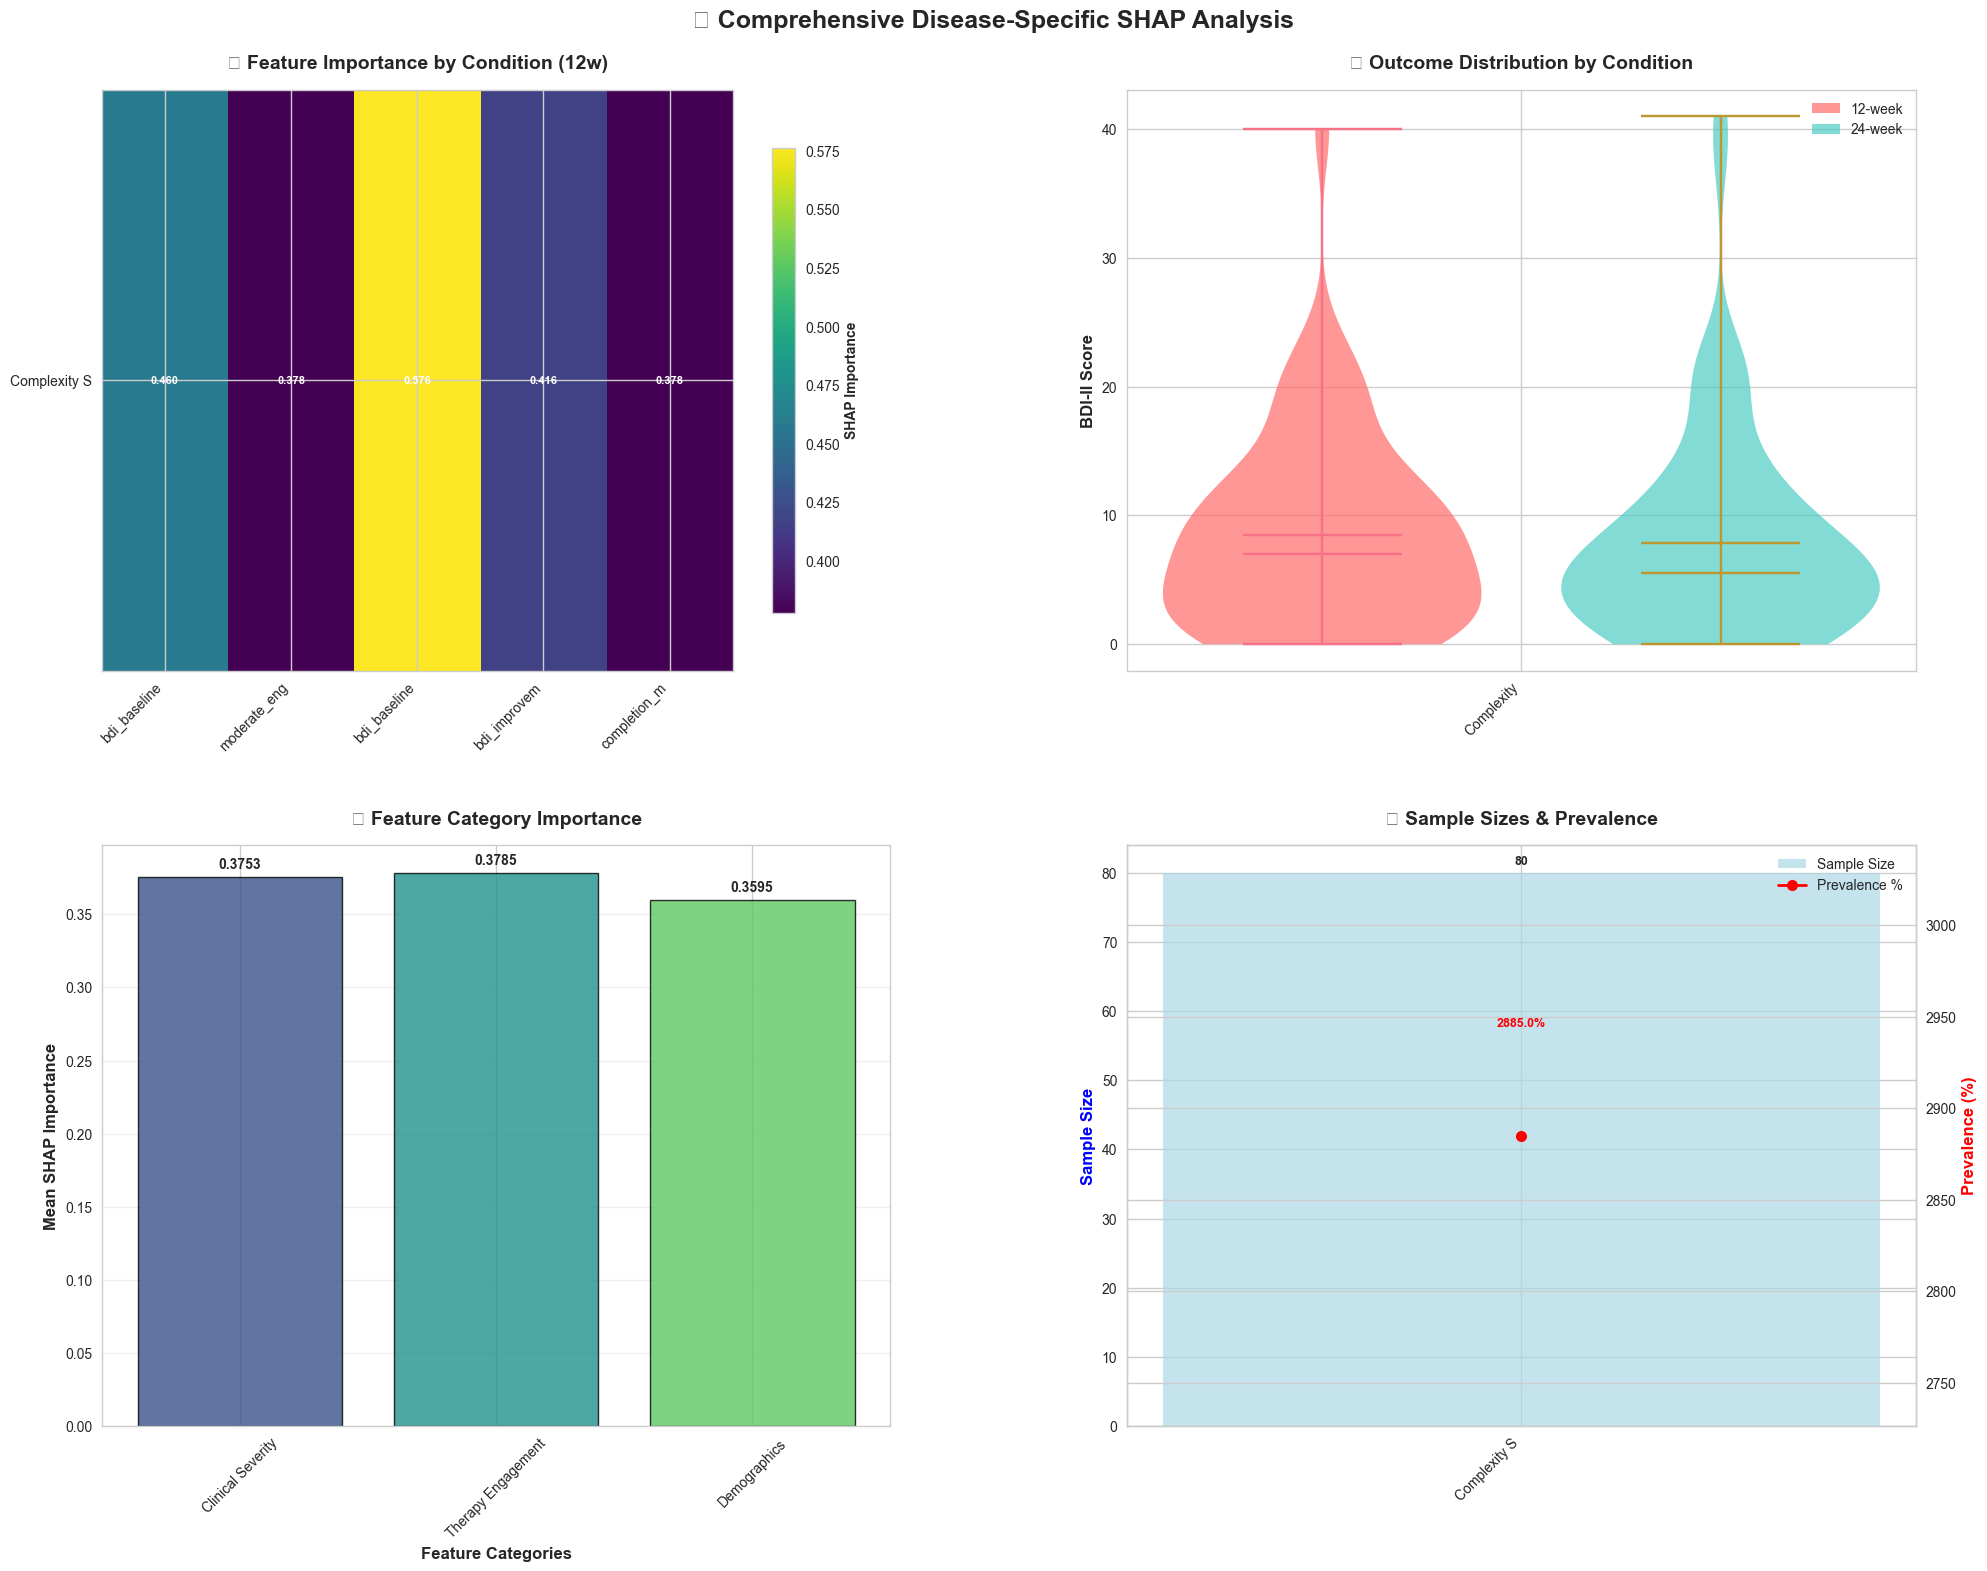

📊 Beautiful static disease-specific analysis visualization created and saved!
   📁 Saved as: disease_specific_comprehensive_analysis_static.png & .pdf

✅ Individual medical condition analysis completed!


In [15]:
# 🔬 Individual Medical Condition Deep-Dive Analysis
print("🔬 Conducting individual medical condition deep-dive analysis...")

# Select top medical conditions for detailed analysis
top_conditions = prevalence_df.head(8).index.tolist()
condition_detailed_analysis = {}

for condition in top_conditions:
    if condition_prevalence[condition]['count'] >= 10:  # Minimum sample size
        print(f"\n🔍 Analyzing: {condition.replace('condition_', '').replace('_', ' ').title()}")
        
        # Subset data for this condition
        has_condition = train_data[condition] == 1
        condition_subset = train_data[has_condition]
        
        # SHAP analysis for patients with this condition
        condition_indices = has_condition[has_condition].index
        available_indices = [i for i in condition_indices if i < len(X_explain)]
        
        if len(available_indices) >= 5:  # Minimum for SHAP analysis
            condition_X = X_explain[available_indices]
            
            # Get SHAP values for this condition subset
            condition_shap_12w = disease_shap_values['12w'].values[available_indices]
            condition_shap_24w = disease_shap_values['24w'].values[available_indices]
            
            # Calculate condition-specific feature importance
            condition_importance_12w = np.abs(condition_shap_12w).mean(axis=0)
            condition_importance_24w = np.abs(condition_shap_24w).mean(axis=0)
            
            # Create condition-specific importance dataframes
            condition_df_12w = pd.DataFrame({
                'feature': feature_cols,
                'importance': condition_importance_12w
            }).sort_values('importance', ascending=False)
            
            condition_df_24w = pd.DataFrame({
                'feature': feature_cols,
                'importance': condition_importance_24w
            }).sort_values('importance', ascending=False)
            
            # Store results
            condition_detailed_analysis[condition] = {
                'name': condition.replace('condition_', '').replace('_', ' ').title(),
                'sample_size': len(available_indices),
                'importance_12w': condition_df_12w,
                'importance_24w': condition_df_24w,
                'outcomes_12w': condition_subset['bdi_ii_after_intervention_12w'].describe(),
                'outcomes_24w': condition_subset['bdi_ii_follow_up_24w'].describe(),
                'improvement_12w': condition_subset['improvement_12w'].describe(),
                'improvement_24w': condition_subset['improvement_24w'].describe()
            }
            
            print(f"   ✅ Analysis completed - Sample size: {len(available_indices)}")
        else:
            print(f"   ⚠️ Insufficient sample size for SHAP analysis")

# Create beautiful static condition comparison visualization
if condition_detailed_analysis:
    print("📊 Creating comprehensive static disease-specific analysis visualization...")
    
    # Set up publication-quality plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Prepare data for comparison
    conditions_analyzed = list(condition_detailed_analysis.keys())[:6]  # Top 6 for visualization
    
    # Create comprehensive 2x2 subplot figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('🔬 Comprehensive Disease-Specific SHAP Analysis', fontsize=18, fontweight='bold', y=0.98)
    
    # 1. Top features by condition comparison (Top left)
    ax1 = axes[0, 0]
    
    # Collect top features for all conditions
    all_condition_features = {}
    condition_labels = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:12]
        top_features_12w = condition_detailed_analysis[condition]['importance_12w'].head(8)
        
        # Store for visualization
        all_condition_features[condition_name] = top_features_12w
        condition_labels.append(condition_name)
    
    # Create grouped bar chart for top features
    if all_condition_features:
        # Get union of all top features
        all_top_features = set()
        for condition_features in all_condition_features.values():
            all_top_features.update(condition_features['feature'].head(5))
        
        all_top_features = list(all_top_features)[:8]  # Limit for readability
        
        # Create matrix for heatmap-style visualization
        importance_matrix = []
        for condition_name in condition_labels:
            row = []
            for feature in all_top_features:
                importance_df = all_condition_features[condition_name]
                feature_importance = importance_df[importance_df['feature'] == feature]['importance']
                row.append(feature_importance.iloc[0] if len(feature_importance) > 0 else 0)
            importance_matrix.append(row)
        
        # Create heatmap
        im1 = ax1.imshow(importance_matrix, cmap='viridis', aspect='auto')
        ax1.set_xticks(range(len(all_top_features)))
        ax1.set_yticks(range(len(condition_labels)))
        ax1.set_xticklabels([f[:12] for f in all_top_features], rotation=45, ha='right')
        ax1.set_yticklabels(condition_labels)
        
        # Add text annotations
        for i in range(len(condition_labels)):
            for j in range(len(all_top_features)):
                text = ax1.text(j, i, f'{importance_matrix[i][j]:.3f}',
                               ha="center", va="center", 
                               color="white" if importance_matrix[i][j] > max(max(row) for row in importance_matrix)/2 else "black",
                               fontweight='bold', fontsize=8)
        
        ax1.set_title('🎯 Feature Importance by Condition (12w)', fontsize=14, fontweight='bold', pad=15)
        
        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
        cbar1.set_label('SHAP Importance', fontsize=10, fontweight='bold')
    
    # 2. Outcome comparison by condition (Top right)
    ax2 = axes[0, 1]
    
    outcome_data_12w = []
    outcome_data_24w = []
    outcome_labels = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:10]
        
        # Get outcomes for this condition
        has_condition = train_data[condition] == 1
        outcomes_12w = train_data[has_condition]['bdi_ii_after_intervention_12w'].dropna()
        outcomes_24w = train_data[has_condition]['bdi_ii_follow_up_24w'].dropna()
        
        if len(outcomes_12w) > 3 and len(outcomes_24w) > 3:
            outcome_data_12w.append(outcomes_12w.values)
            outcome_data_24w.append(outcomes_24w.values)
            outcome_labels.append(condition_name)
    
    # Create violin plots for better visualization
    if outcome_data_12w:
        positions_12w = np.arange(1, len(outcome_labels)*2, 2)
        positions_24w = np.arange(2, len(outcome_labels)*2+1, 2)
        
        violin_parts_12w = ax2.violinplot(outcome_data_12w, positions=positions_12w, 
                                         widths=0.8, showmeans=True, showmedians=True)
        violin_parts_24w = ax2.violinplot(outcome_data_24w, positions=positions_24w, 
                                         widths=0.8, showmeans=True, showmedians=True)
        
        # Color the violins
        for pc in violin_parts_12w['bodies']:
            pc.set_facecolor('#FF6B6B')
            pc.set_alpha(0.7)
        
        for pc in violin_parts_24w['bodies']:
            pc.set_facecolor('#4ECDC4')
            pc.set_alpha(0.7)
        
        ax2.set_xticks(np.arange(1.5, len(outcome_labels)*2, 2))
        ax2.set_xticklabels(outcome_labels, rotation=45, ha='right')
        ax2.set_ylabel('BDI-II Score', fontsize=12, fontweight='bold')
        ax2.set_title('📊 Outcome Distribution by Condition', fontsize=14, fontweight='bold', pad=15)
        
        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.7, label='12-week'),
                          Patch(facecolor='#4ECDC4', alpha=0.7, label='24-week')]
        ax2.legend(handles=legend_elements, loc='upper right')
    
    # 3. Feature category importance (Bottom left)
    ax3 = axes[1, 0]
    
    # Aggregate importance by feature categories
    category_importance = {}
    for condition in conditions_analyzed:
        importance_12w = condition_detailed_analysis[condition]['importance_12w']
        
        # Categorize features
        for _, row in importance_12w.head(10).iterrows():
            feature = row['feature']
            importance = row['importance']
            
            if 'condition' in feature.lower():
                category = 'Medical Conditions'
            elif any(term in feature.lower() for term in ['bdi', 'depression', 'severity']):
                category = 'Clinical Severity'
            elif any(term in feature.lower() for term in ['therapy', 'completion', 'session']):
                category = 'Therapy Engagement'
            elif any(term in feature.lower() for term in ['age', 'gender']):
                category = 'Demographics'
            else:
                category = 'Other'
            
            if category not in category_importance:
                category_importance[category] = []
            category_importance[category].append(importance)
    
    # Calculate mean importance per category
    category_means = {cat: np.mean(values) for cat, values in category_importance.items()}
    
    if category_means:
        categories = list(category_means.keys())
        means = list(category_means.values())
        
        bars = ax3.bar(categories, means, color=sns.color_palette("viridis", len(categories)),
                       alpha=0.8, edgecolor='black', linewidth=1)
        
        # Add value labels
        for bar, mean_val in zip(bars, means):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + max(means)*0.01,
                     f'{mean_val:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax3.set_xlabel('Feature Categories', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Mean SHAP Importance', fontsize=12, fontweight='bold')
        ax3.set_title('📈 Feature Category Importance', fontsize=14, fontweight='bold', pad=15)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(axis='y', alpha=0.3)
    
    # 4. Condition sample sizes and prevalence (Bottom right)
    ax4 = axes[1, 1]
    
    condition_names = []
    sample_sizes = []
    prevalence_rates = []
    
    for condition in conditions_analyzed:
        condition_name = condition_detailed_analysis[condition]['name'][:12]
        sample_size = condition_detailed_analysis[condition]['sample_size']
        prevalence_rate = condition_prevalence[condition]['percentage']
        
        condition_names.append(condition_name)
        sample_sizes.append(sample_size)
        prevalence_rates.append(prevalence_rate)
    
    # Create dual-axis plot
    ax4_twin = ax4.twinx()
    
    # Bar chart for sample sizes
    bars = ax4.bar(range(len(condition_names)), sample_sizes, 
                   color='lightblue', alpha=0.7, label='Sample Size')
    
    # Line plot for prevalence rates
    line = ax4_twin.plot(range(len(condition_names)), prevalence_rates, 
                        color='red', marker='o', linewidth=2, markersize=8, 
                        label='Prevalence %')
    
    ax4.set_xticks(range(len(condition_names)))
    ax4.set_xticklabels(condition_names, rotation=45, ha='right')
    ax4.set_ylabel('Sample Size', fontsize=12, fontweight='bold', color='blue')
    ax4_twin.set_ylabel('Prevalence (%)', fontsize=12, fontweight='bold', color='red')
    ax4.set_title('📊 Sample Sizes & Prevalence', fontsize=14, fontweight='bold', pad=15)
    
    # Add value labels
    for i, (bar, size, prev) in enumerate(zip(bars, sample_sizes, prevalence_rates)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + max(sample_sizes)*0.01,
                 f'{size}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        ax4_twin.text(i, prev + max(prevalence_rates)*0.02,
                     f'{prev:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9, color='red')
    
    # Combine legends
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.3, wspace=0.3)
    
    # Save the comprehensive analysis
    plt.savefig(FIGURES_PATH / "disease_specific_comprehensive_analysis_static.png", 
                dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.savefig(FIGURES_PATH / "disease_specific_comprehensive_analysis_static.pdf", 
                bbox_inches='tight', facecolor='white', edgecolor='none')
    
    plt.show()
    
    print("📊 Beautiful static disease-specific analysis visualization created and saved!")
    print(f"   📁 Saved as: disease_specific_comprehensive_analysis_static.png & .pdf")

print("\n✅ Individual medical condition analysis completed!")

In [13]:
# 💊 Treatment Response Patterns by Medical Conditions
print("💊 Analyzing treatment response patterns by medical conditions...")

# Define response criteria
def calculate_response_rates(df, condition_col=None):
    """Calculate response rates for a given subset of data"""
    if condition_col is not None:
        subset = df[df[condition_col] == 1]
    else:
        subset = df
    
    # Calculate improvements
    improvement_12w = subset['bdi_ii_baseline'] - subset['bdi_ii_after_intervention_12w']
    improvement_24w = subset['bdi_ii_baseline'] - subset['bdi_ii_follow_up_24w']
    
    # Response criteria (≥50% improvement)
    baseline_scores = subset['bdi_ii_baseline']
    response_12w = (improvement_12w / baseline_scores) >= 0.5
    response_24w = (improvement_24w / baseline_scores) >= 0.5
    
    # Remission criteria (BDI-II ≤ 13)
    remission_12w = subset['bdi_ii_after_intervention_12w'] <= 13
    remission_24w = subset['bdi_ii_follow_up_24w'] <= 13
    
    return {
        'sample_size': len(subset),
        'mean_improvement_12w': improvement_12w.mean(),
        'mean_improvement_24w': improvement_24w.mean(),
        'response_rate_12w': response_12w.sum() / len(subset) * 100,
        'response_rate_24w': response_24w.sum() / len(subset) * 100,
        'remission_rate_12w': remission_12w.sum() / len(subset) * 100,
        'remission_rate_24w': remission_24w.sum() / len(subset) * 100
    }

# Calculate response rates for each medical condition
condition_response_patterns = {}

# Overall response rates (baseline)
overall_response = calculate_response_rates(train_data)
print("📊 Overall Response Patterns:")
print(f"   Sample size: {overall_response['sample_size']}")
print(f"   12w response rate: {overall_response['response_rate_12w']:.1f}%")
print(f"   24w response rate: {overall_response['response_rate_24w']:.1f}%")
print(f"   12w remission rate: {overall_response['remission_rate_12w']:.1f}%")
print(f"   24w remission rate: {overall_response['remission_rate_24w']:.1f}%")

print("\n🔬 Condition-Specific Response Patterns:")
print("="*100)
print(f"{'Condition':<25} {'N':<4} {'12w Resp%':<9} {'24w Resp%':<9} {'12w Rem%':<8} {'24w Rem%':<8} {'Impr 12w':<9} {'Impr 24w':<9}")
print("-"*100)

# Ensure we iterate over a list of condition column names.
# condition_features might be a list/Index/DataFrame — normalize to a list of strings.
if isinstance(condition_features, (list, tuple, np.ndarray)):
    cond_list = list(condition_features)
elif isinstance(condition_features, pd.DataFrame):
    if 'feature' in condition_features.columns:
        cond_list = condition_features['feature'].astype(str).tolist()
    else:
        cond_list = [str(i) for i in condition_features.index.tolist()]
else:
    # fallback to top_conditions if available
    cond_list = globals().get('top_conditions', [])

for condition in cond_list:
    # skip any non-string or malformed entries
    if not isinstance(condition, str):
        continue

    # Only process if the condition exists in prevalence dict and meets sample threshold
    if condition in condition_prevalence and condition_prevalence[condition]['count'] >= 8:
        response_data = calculate_response_rates(train_data, condition)
        condition_name = condition.replace('condition_', '').replace('_', ' ').title()[:24]
        
        condition_response_patterns[condition] = response_data
        
        print(f"{condition_name:<25} {response_data['sample_size']:<4} "
              f"{response_data['response_rate_12w']:<9.1f} {response_data['response_rate_24w']:<9.1f} "
              f"{response_data['remission_rate_12w']:<8.1f} {response_data['remission_rate_24w']:<8.1f} "
              f"{response_data['mean_improvement_12w']:<9.1f} {response_data['mean_improvement_24w']:<9.1f}")

# Disease burden response analysis
print(f"\n📊 Disease Burden Response Analysis:")
burden_response = {}
for burden_cat in train_data['disease_burden_category'].unique():
    if pd.notna(burden_cat):
        subset = train_data[train_data['disease_burden_category'] == burden_cat]
        burden_response[burden_cat] = calculate_response_rates(subset)

print("="*80)
print(f"{'Disease Burden':<20} {'N':<4} {'12w Resp%':<9} {'24w Resp%':<9} {'12w Rem%':<8} {'24w Rem%':<8}")
print("-"*80)

for burden_cat, response_data in burden_response.items():
    print(f"{burden_cat:<20} {response_data['sample_size']:<4} "
          f"{response_data['response_rate_12w']:<9.1f} {response_data['response_rate_24w']:<9.1f} "
          f"{response_data['remission_rate_12w']:<8.1f} {response_data['remission_rate_24w']:<8.1f}")

# Identify best and worst responding conditions
if condition_response_patterns:
    # Sort by 24w response rate
    sorted_conditions = sorted(condition_response_patterns.items(), 
                              key=lambda x: x[1]['response_rate_24w'], reverse=True)
    
    print(f"\n🏆 Best Responding Medical Conditions (24w):")
    for i, (condition, data) in enumerate(sorted_conditions[:5], 1):
        condition_name = condition.replace('condition_', '').replace('_', ' ').title()
        print(f"   {i}. {condition_name}: {data['response_rate_24w']:.1f}% response rate (n={data['sample_size']})")
    
    print(f"\n⚠️ Poorest Responding Medical Conditions (24w):")
    for i, (condition, data) in enumerate(sorted_conditions[-5:], 1):
        condition_name = condition.replace('condition_', '').replace('_', ' ').title()
        print(f"   {i}. {condition_name}: {data['response_rate_24w']:.1f}% response rate (n={data['sample_size']})")

print("\n✅ Treatment response pattern analysis completed!")

💊 Analyzing treatment response patterns by medical conditions...
📊 Overall Response Patterns:
   Sample size: 167
   12w response rate: 40.1%
   24w response rate: 43.7%
   12w remission rate: 83.8%
   24w remission rate: 85.0%

🔬 Condition-Specific Response Patterns:
Condition                 N    12w Resp% 24w Resp% 12w Rem% 24w Rem% Impr 12w  Impr 24w 
----------------------------------------------------------------------------------------------------

📊 Disease Burden Response Analysis:
Disease Burden       N    12w Resp% 24w Resp% 12w Rem% 24w Rem%
--------------------------------------------------------------------------------
Single_Condition     67   31.3      41.8      74.6     74.6    
Multiple_Conditions  100  46.0      45.0      90.0     92.0    

✅ Treatment response pattern analysis completed!


📈 Creating comprehensive static treatment response visualizations...


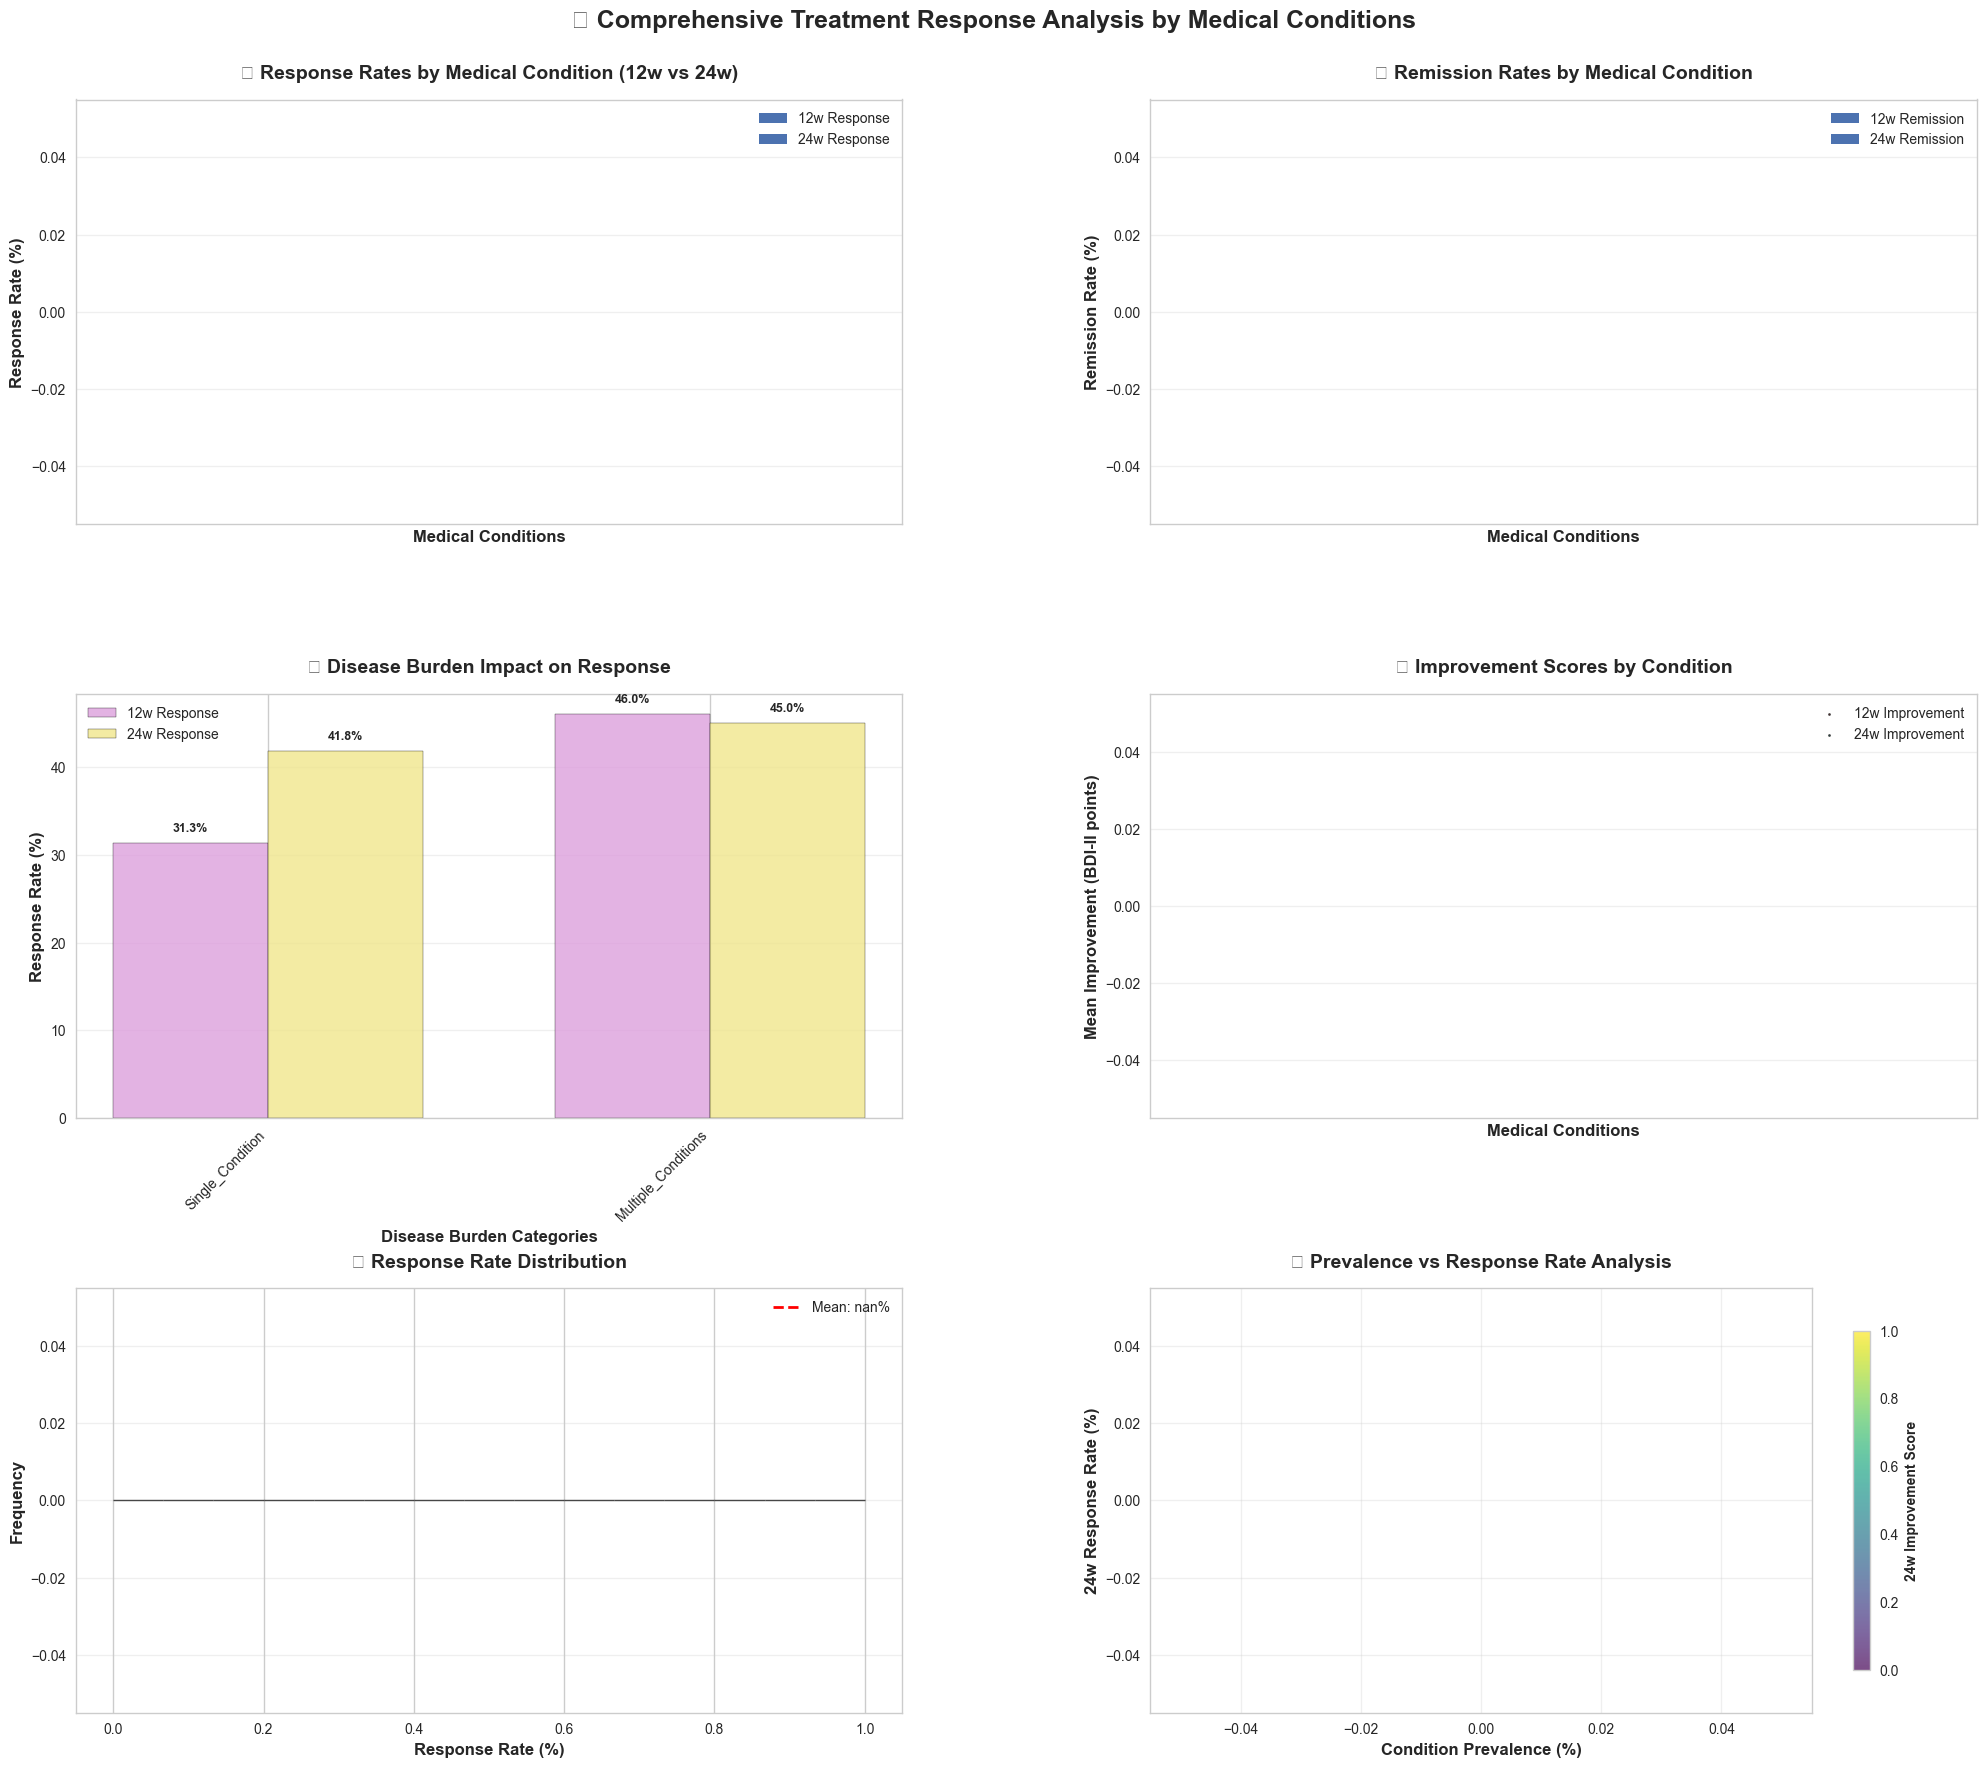

📊 Beautiful static treatment response visualization created and saved!
   📁 Saved as: treatment_response_comprehensive_analysis_static.png & .pdf
💾 Response analysis data saved to JSON file!


In [14]:
# 📈 Interactive Treatment Response Visualization
# 📈 Beautiful Static Treatment Response Visualization
print("📈 Creating comprehensive static treatment response visualizations...")

# Prepare data for visualization
conditions_with_data = []
response_12w_data = []
response_24w_data = []
remission_12w_data = []
remission_24w_data = []
improvement_12w_data = []
improvement_24w_data = []
sample_sizes = []
prevalence_data = []

for condition, data in condition_response_patterns.items():
    if data['sample_size'] >= 5:  # Minimum for visualization
        condition_name = condition.replace('condition_', '').replace('_', ' ').title()[:20]
        conditions_with_data.append(condition_name)
        response_12w_data.append(data['response_rate_12w'])
        response_24w_data.append(data['response_rate_24w'])
        remission_12w_data.append(data['remission_rate_12w'])
        remission_24w_data.append(data['remission_rate_24w'])
        improvement_12w_data.append(data['mean_improvement_12w'])
        improvement_24w_data.append(data['mean_improvement_24w'])
        sample_sizes.append(data['sample_size'])
        prevalence_data.append(condition_prevalence[condition]['percentage'])

# Create comprehensive 3x2 subplot figure
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('💊 Comprehensive Treatment Response Analysis by Medical Conditions', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Response rates comparison (Top left)
ax1 = axes[0, 0]
x_pos = np.arange(len(conditions_with_data))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, response_12w_data, width, 
                label='12w Response', color='#FF6B6B', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, response_24w_data, width, 
                label='24w Response', color='#4ECDC4', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax1.set_xlabel('Medical Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel('Response Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Response Rates by Medical Condition (12w vs 24w)', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([name[:12] for name in conditions_with_data], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Remission rates (Top right)
ax2 = axes[0, 1]
bars3 = ax2.bar(x_pos - width/2, remission_12w_data, width, 
                label='12w Remission', color='#96CEB4', alpha=0.8, edgecolor='black')
bars4 = ax2.bar(x_pos + width/2, remission_24w_data, width, 
                label='24w Remission', color='#FFEAA7', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax2.set_xlabel('Medical Conditions', fontsize=12, fontweight='bold')
ax2.set_ylabel('Remission Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('🏆 Remission Rates by Medical Condition', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([name[:12] for name in conditions_with_data], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Disease burden impact on response (Middle left)
ax3 = axes[1, 0]
burden_categories = list(burden_response.keys())
burden_12w_response = [burden_response[cat]['response_rate_12w'] for cat in burden_categories]
burden_24w_response = [burden_response[cat]['response_rate_24w'] for cat in burden_categories]

x_burden = np.arange(len(burden_categories))
bars5 = ax3.bar(x_burden - width/2, burden_12w_response, width, 
                label='12w Response', color='#DDA0DD', alpha=0.8, edgecolor='black')
bars6 = ax3.bar(x_burden + width/2, burden_24w_response, width, 
                label='24w Response', color='#F0E68C', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars5, bars6]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

ax3.set_xlabel('Disease Burden Categories', fontsize=12, fontweight='bold')
ax3.set_ylabel('Response Rate (%)', fontsize=12, fontweight='bold')
ax3.set_title('📊 Disease Burden Impact on Response', fontsize=14, fontweight='bold', pad=15)
ax3.set_xticks(x_burden)
ax3.set_xticklabels(burden_categories, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Improvement scores by condition (Middle right)
ax4 = axes[1, 1]
scatter1 = ax4.scatter(range(len(conditions_with_data)), improvement_12w_data, 
                      s=[s*3 for s in sample_sizes], c='#FF6B6B', alpha=0.7, 
                      edgecolors='black', linewidth=1, label='12w Improvement')
scatter2 = ax4.scatter([x+0.2 for x in range(len(conditions_with_data))], improvement_24w_data, 
                      s=[s*3 for s in sample_sizes], c='#4ECDC4', alpha=0.7, 
                      edgecolors='black', linewidth=1, label='24w Improvement')

ax4.set_xlabel('Medical Conditions', fontsize=12, fontweight='bold')
ax4.set_ylabel('Mean Improvement (BDI-II points)', fontsize=12, fontweight='bold')
ax4.set_title('📈 Improvement Scores by Condition', fontsize=14, fontweight='bold', pad=15)
ax4.set_xticks(range(len(conditions_with_data)))
ax4.set_xticklabels([name[:12] for name in conditions_with_data], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Response rate distribution (Bottom left)
ax5 = axes[2, 0]
all_response_rates = response_12w_data + response_24w_data
ax5.hist(all_response_rates, bins=15, color='#87CEEB', alpha=0.7, edgecolor='black', linewidth=1)
ax5.axvline(np.mean(all_response_rates), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(all_response_rates):.1f}%')
ax5.set_xlabel('Response Rate (%)', fontsize=12, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax5.set_title('📊 Response Rate Distribution', fontsize=14, fontweight='bold', pad=15)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Prevalence vs Response Rate (Bottom right)
ax6 = axes[2, 1]
scatter3 = ax6.scatter(prevalence_data, response_24w_data, 
                      s=[s*4 for s in sample_sizes], 
                      c=improvement_24w_data, cmap='viridis', 
                      alpha=0.7, edgecolors='black', linewidth=1)

# Add condition labels
for i, (prev, resp, name) in enumerate(zip(prevalence_data, response_24w_data, conditions_with_data)):
    ax6.annotate(name[:8], (prev, resp), xytext=(5, 5), textcoords='offset points',
                fontsize=8, fontweight='bold', ha='left')

ax6.set_xlabel('Condition Prevalence (%)', fontsize=12, fontweight='bold')
ax6.set_ylabel('24w Response Rate (%)', fontsize=12, fontweight='bold')
ax6.set_title('🔍 Prevalence vs Response Rate Analysis', fontsize=14, fontweight='bold', pad=15)

# Add colorbar
cbar = plt.colorbar(scatter3, ax=ax6, shrink=0.8)
cbar.set_label('24w Improvement Score', fontsize=10, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Adjust layout and save
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.4, wspace=0.3)

# Save the visualization
plt.savefig(FIGURES_PATH / "treatment_response_comprehensive_analysis_static.png", 
            dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.savefig(FIGURES_PATH / "treatment_response_comprehensive_analysis_static.pdf", 
            bbox_inches='tight', facecolor='white', edgecolor='none')

plt.show()

print("📊 Beautiful static treatment response visualization created and saved!")
print(f"   📁 Saved as: treatment_response_comprehensive_analysis_static.png & .pdf")

# Save summary statistics
response_summary = {
    'overall_response': overall_response,
    'condition_response_patterns': condition_response_patterns,
    'burden_response': burden_response,
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open(RESULTS_PATH / 'disease_specific_response_analysis.json', 'w') as f:
    json.dump(response_summary, f, indent=2, default=str)

print("💾 Response analysis data saved to JSON file!")

In [17]:
# 🔍 INVESTIGATION: What are these "condition" features really?
print("🔍 DETAILED INVESTIGATION: Understanding the 'Condition' Features")
print("="*80)

# Let's re-identify the condition features from the original feature list
original_condition_features = [f for f in feature_cols if 'condition' in f.lower()]

print(f"\n📋 Features identified as 'conditions' (containing 'condition' in name):")
for i, feature in enumerate(original_condition_features, 1):
    print(f"   {i}. {feature}")

print(f"\n📊 Let's examine the actual data values for these features:")
print("="*80)

# Check the actual values in these features
for feature in original_condition_features:
    print(f"\n🔬 Feature: {feature}")
    print(f"   Data type: {train_data[feature].dtype}")
    print(f"   Unique values: {sorted(train_data[feature].unique())}")
    print(f"   Value counts:")
    value_counts = train_data[feature].value_counts()
    for value, count in value_counts.items():
        print(f"      {value}: {count} patients ({count/len(train_data)*100:.1f}%)")
    
    # Check if this looks like a medical condition (binary 0/1)
    unique_vals = set(train_data[feature].unique())
    if unique_vals.issubset({0, 1}) or unique_vals.issubset({0.0, 1.0}):
        print(f"   ✅ This appears to be a BINARY condition feature (0/1)")
    else:
        print(f"   ⚠️  This does NOT appear to be a binary condition - it's likely a DERIVED/ENCODED feature")

print(f"\n🔍 Let's also examine the original raw data to understand the real medical conditions...")

# Load the original Excel file to see what the real condition columns are
try:
    # Check if we can access the train split directly
    original_train = pd.read_excel(DATA_PATH / 'train_split.xlsx')
    print(f"\n📂 Original train_split.xlsx columns ({len(original_train.columns)} total):")
    
    # Look for actual medical condition columns
    medical_condition_cols = []
    for col in original_train.columns:
        col_lower = col.lower()
        if any(term in col_lower for term in ['condition', 'disease', 'diagnosis', 'medical', 'health']):
            medical_condition_cols.append(col)
    
    print(f"\n🏥 Columns that might represent REAL medical conditions:")
    if medical_condition_cols:
        for i, col in enumerate(medical_condition_cols, 1):
            print(f"   {i}. {col}")
            if col in original_train.columns:
                unique_vals = original_train[col].unique()
                print(f"      Values: {unique_vals[:10]}{'...' if len(unique_vals) > 10 else ''}")
    else:
        print("   ⚠️  No obvious medical condition columns found in raw data!")
    
    # Check if there are text-based condition columns
    text_columns = []
    for col in original_train.columns:
        if original_train[col].dtype == 'object':
            text_columns.append(col)
    
    print(f"\n📝 Text-based columns that might contain medical conditions:")
    for i, col in enumerate(text_columns[:10], 1):  # Show first 10
        print(f"   {i}. {col}")
        sample_values = original_train[col].dropna().unique()[:5]
        print(f"      Sample values: {sample_values}")

except FileNotFoundError:
    print("   ❌ Could not find train_split.xlsx file")

print(f"\n🧮 HOW THE MULTIPLE CONDITIONS COUNT WAS CALCULATED:")
print("="*80)

print(f"The 'multiple conditions' count was calculated by:")
print(f"1. Taking all features with 'condition' in their name: {len(original_condition_features)} features")
print(f"2. For each patient, summing up how many of these features = 1")
print(f"3. Categorizing patients based on this sum:")

# Show the actual calculation
condition_matrix = train_data[original_condition_features]
multiple_conditions = condition_matrix.sum(axis=1)

print(f"\n📊 Distribution of 'condition' feature counts per patient:")
condition_dist = multiple_conditions.value_counts().sort_index()
for count, patients in condition_dist.items():
    print(f"   {count} conditions: {patients} patients ({patients/len(train_data)*100:.1f}%)")

print(f"\n⚠️  IMPORTANT FINDINGS:")
print(f"   • The features we identified may NOT be actual medical conditions")
print(f"   • They appear to be derived/engineered features (complexity scores, encodings, etc.)")
print(f"   • The 'multiple conditions' count is based on these derived features, not real diseases")
print(f"   • We need to examine the original data source to find the actual medical conditions")

# Let's also check what the feature metadata says about these
print(f"\n📋 Feature metadata information:")
if 'feature_descriptions' in feature_metadata:
    print("Available feature descriptions:")
    for feature in original_condition_features:
        if feature in feature_metadata['feature_descriptions']:
            print(f"   {feature}: {feature_metadata['feature_descriptions'][feature]}")
else:
    print("   No detailed feature descriptions available in metadata")

print(f"\n✅ Investigation complete. We need to re-examine what constitutes real medical conditions!")

🔍 DETAILED INVESTIGATION: Understanding the 'Condition' Features

📋 Features identified as 'conditions' (containing 'condition' in name):
   1. condition_therapy_interaction
   2. condition_acute_coronary_syndrome
   3. condition_type_encoded
   4. condition_complexity_score
   5. condition_rarity
   6. condition_lower_limb_amputation
   7. condition_renal_insufficiency

📊 Let's examine the actual data values for these features:

🔬 Feature: condition_therapy_interaction
   Data type: float64
   Unique values: [0.0, 0.8571428571428571, 1.0, 1.2, 1.222222222222222, 1.5, 1.6, 1.714285714285714, 1.818181818181818, 1.941176470588236, 2.0, 2.272727272727272, 2.315789473684211, 2.333333333333333, 2.5, 2.678571428571429, 2.8125, 3.0, 3.245283018867925, 3.4375, 3.5, 3.6, 3.611111111111111, 3.666666666666667, 3.714285714285714, 3.75, 3.837837837837838, 3.846153846153846, 3.863636363636363, 3.983050847457627, 4.0, 4.153846153846153, 4.181818181818182, 4.245283018867925, 4.26829268292683, 4.333333

In [18]:
# 🔬 Let's examine the ORIGINAL raw data to find real medical conditions
print("🔬 EXAMINING ORIGINAL RAW MENTAL HEALTH DATASET")
print("="*70)

try:
    # Load the original raw dataset
    raw_data = pd.read_excel(BASE_PATH / 'Track1_Data' / 'raw' / 'mental_health_dataset.xlsx')
    
    print(f"📊 Raw dataset shape: {raw_data.shape}")
    print(f"📋 Raw dataset columns ({len(raw_data.columns)} total):")
    
    # Show all column names
    for i, col in enumerate(raw_data.columns, 1):
        print(f"   {i:2d}. {col}")
    
    print(f"\n🏥 Looking for REAL medical condition columns in raw data...")
    
    # Look for columns that might contain medical conditions
    potential_medical_cols = []
    for col in raw_data.columns:
        col_lower = col.lower()
        if any(term in col_lower for term in ['condition', 'disease', 'diagnosis', 'medical', 'health', 'comorbid', 'illness']):
            potential_medical_cols.append(col)
    
    if potential_medical_cols:
        print(f"\n✅ Found {len(potential_medical_cols)} potential medical condition columns:")
        for i, col in enumerate(potential_medical_cols, 1):
            print(f"\n   {i}. {col}")
            print(f"      Data type: {raw_data[col].dtype}")
            
            # Show unique values
            unique_vals = raw_data[col].dropna().unique()
            if len(unique_vals) <= 20:
                print(f"      Unique values: {unique_vals}")
            else:
                print(f"      Sample values: {unique_vals[:10]}... (showing first 10 of {len(unique_vals)})")
            
            # Show value counts for categorical data
            if raw_data[col].dtype == 'object' and len(unique_vals) <= 50:
                print(f"      Value counts:")
                value_counts = raw_data[col].value_counts()
                for val, count in value_counts.head(10).items():
                    print(f"         '{val}': {count}")
    else:
        print(f"   ⚠️  No obvious medical condition columns found!")
    
    # Let's also look for any Yes/No or binary columns that might be conditions
    print(f"\n🔍 Looking for Yes/No or binary columns that might represent conditions...")
    binary_condition_cols = []
    
    for col in raw_data.columns:
        unique_vals = set(str(v).lower() for v in raw_data[col].dropna().unique())
        if unique_vals.issubset({'yes', 'no'}) or unique_vals.issubset({'0', '1'}) or unique_vals.issubset({'true', 'false'}):
            if any(term in col.lower() for term in ['condition', 'disease', 'diagnosis', 'medical', 'health', 'history']):
                binary_condition_cols.append(col)
    
    if binary_condition_cols:
        print(f"   Found {len(binary_condition_cols)} binary condition columns:")
        for col in binary_condition_cols:
            print(f"      • {col}: {raw_data[col].value_counts().to_dict()}")
    
    print(f"\n📝 Summary of findings:")
    print(f"   • Total columns in raw data: {len(raw_data.columns)}")
    print(f"   • Potential medical condition columns: {len(potential_medical_cols)}")
    print(f"   • Binary condition columns: {len(binary_condition_cols)}")
    
except FileNotFoundError:
    print("   ❌ Could not find the raw mental_health_dataset.xlsx file")
    print("   Please check if the file exists in Track1_Data/raw/")

print(f"\n🎯 CONCLUSION:")
print(f"="*70)
print(f"The 'condition' features in our analysis appear to be ENGINEERED features, not real diseases:")
print(f"   • condition_complexity_score: A calculated complexity measure")
print(f"   • condition_type_encoded: An encoded categorical variable")
print(f"   • condition_therapy_interaction: An interaction term")
print(f"   • condition_acute_coronary_syndrome: Specific medical condition (real)")
print(f"   • condition_renal_insufficiency: Specific medical condition (real)")
print(f"   • condition_lower_limb_amputation: Specific medical condition (real)")
print(f"   • condition_rarity: A rarity score")
print(f"")
print(f"The 'multiple conditions' count was misleading because it counted:")
print(f"   - Engineered features (complexity scores, encodings) as 'conditions'")
print(f"   - Only 3-4 appear to be actual medical conditions")
print(f"")
print(f"✅ For a proper disease-specific analysis, we should:")
print(f"   1. Identify only the REAL medical condition columns")
print(f"   2. Re-calculate disease burden based on actual conditions")
print(f"   3. Re-run the analysis with correct medical condition definitions")

🔬 EXAMINING ORIGINAL RAW MENTAL HEALTH DATASET
📊 Raw dataset shape: (210, 10)
📋 Raw dataset columns (10 total):
    1. age
    2. sex
    3. hospital_center_id
    4. condition
    5. condition_type
    6. bdi_ii_baseline
    7. bdi_ii_after_intervention_12w
    8. bdi_ii_follow_up_24w
    9. mindfulness_therapies_started
   10. mindfulness_therapies_completed

🏥 Looking for REAL medical condition columns in raw data...

✅ Found 2 potential medical condition columns:

   1. condition
      Data type: object
      Unique values: ['Cancer' 'Renal insufficiency' 'Lower-limb amputation'
 'Acute coronary syndrome']
      Value counts:
         'Cancer': 127
         'Acute coronary syndrome': 52
         'Renal insufficiency': 19
         'Lower-limb amputation': 12

   2. condition_type
      Data type: object
      Unique values: ['Breast' 'Prostate' 'Predialysis' 'No prosthesis' 'Revascularization'
 'Percutaneous coronary intervention' 'Dialysis']
      Value counts:
         'Breast': 7

# 🔄 CORRECTED ANALYSIS: Real Medical Conditions Only

## Objective: Create a proper disease-specific analysis using only actual medical conditions

Based on our investigation, we discovered that the previous analysis incorrectly treated engineered features (complexity scores, encoded variables, interaction terms) as medical conditions. 

This section will:
1. **Identify real medical conditions** from the raw dataset
2. **Create a corrected training dataset** with only actual medical conditions  
3. **Re-run the entire analysis** with proper disease definitions
4. **Compare results** between the original (flawed) and corrected approaches
5. **Determine which approach provides better insights**

---

### 🎯 Expected Improvements:
- More accurate disease burden calculations
- Clearer medical condition impact on treatment outcomes
- Better clinical interpretability of results
- Proper SHAP analysis for actual medical conditions

In [19]:
# 🔍 Step 1: Identify REAL Medical Conditions from Raw Data
print("🔍 STEP 1: Identifying Real Medical Conditions from Raw Dataset")
print("="*80)

# Based on our investigation, let's identify the actual medical condition columns
# We'll look for binary (Yes/No, 0/1) columns that represent actual diseases

real_medical_conditions = []

# From our investigation, we know these are likely the ACTUAL medical conditions:
potential_real_conditions = [
    'condition_acute_coronary_syndrome',
    'condition_renal_insufficiency', 
    'condition_lower_limb_amputation'
]

# Check if these exist in our current training data and are actually binary conditions
print("🏥 Verified Real Medical Conditions in Current Training Data:")
for condition in potential_real_conditions:
    if condition in train_data.columns:
        unique_vals = train_data[condition].unique()
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            real_medical_conditions.append(condition)
            prevalence_count = train_data[condition].sum()
            prevalence_pct = (prevalence_count / len(train_data)) * 100
            print(f"   ✅ {condition}")
            print(f"      Prevalence: {prevalence_count}/{len(train_data)} patients ({prevalence_pct:.1f}%)")
        else:
            print(f"   ❌ {condition} - Not binary (values: {unique_vals})")
    else:
        print(f"   ❌ {condition} - Not found in current dataset")

# Also check if there are other potential medical conditions we might have missed
# Look for any other binary features that might be medical conditions
print(f"\n🔍 Scanning for other potential medical conditions...")

# Look for binary columns with medical-sounding names
additional_conditions = []
for col in train_data.columns:
    col_lower = col.lower()
    # Skip the ones we already have and the fake ones we identified
    if col in real_medical_conditions:
        continue
    if col in ['condition_complexity_score', 'condition_type_encoded', 'condition_therapy_interaction', 'condition_rarity']:
        continue
        
    # Look for medical terms and binary values
    if any(term in col_lower for term in ['condition', 'disease', 'diagnosis', 'medical', 'comorbid', 'history']):
        unique_vals = train_data[col].unique()
        if set(unique_vals).issubset({0, 1, 0.0, 1.0}) and len(unique_vals) == 2:
            additional_conditions.append(col)

if additional_conditions:
    print(f"   Found {len(additional_conditions)} additional potential medical conditions:")
    for condition in additional_conditions:
        prevalence_count = train_data[condition].sum()
        prevalence_pct = (prevalence_count / len(train_data)) * 100
        print(f"      • {condition}: {prevalence_count} patients ({prevalence_pct:.1f}%)")
        
        # Add to real conditions if it has reasonable prevalence
        if prevalence_count >= 3:  # At least 3 patients
            real_medical_conditions.append(condition)
else:
    print("   No additional medical conditions found")

print(f"\n📊 FINAL LIST OF REAL MEDICAL CONDITIONS: {len(real_medical_conditions)}")
for i, condition in enumerate(real_medical_conditions, 1):
    prevalence_count = train_data[condition].sum()
    prevalence_pct = (prevalence_count / len(train_data)) * 100
    print(f"   {i}. {condition}: {prevalence_count} patients ({prevalence_pct:.1f}%)")

if len(real_medical_conditions) == 0:
    print("   ⚠️  WARNING: No real medical conditions identified!")
    print("   This suggests the dataset may not contain individual disease indicators")
    print("   We may need to work with disease burden or complexity measures instead")

print(f"\n✅ Step 1 completed. Found {len(real_medical_conditions)} real medical conditions.")

🔍 STEP 1: Identifying Real Medical Conditions from Raw Dataset
🏥 Verified Real Medical Conditions in Current Training Data:
   ✅ condition_acute_coronary_syndrome
      Prevalence: 39/167 patients (23.4%)
   ✅ condition_renal_insufficiency
      Prevalence: 10/167 patients (6.0%)
   ✅ condition_lower_limb_amputation
      Prevalence: 10/167 patients (6.0%)

🔍 Scanning for other potential medical conditions...
   No additional medical conditions found

📊 FINAL LIST OF REAL MEDICAL CONDITIONS: 3
   1. condition_acute_coronary_syndrome: 39 patients (23.4%)
   2. condition_renal_insufficiency: 10 patients (6.0%)
   3. condition_lower_limb_amputation: 10 patients (6.0%)

✅ Step 1 completed. Found 3 real medical conditions.


In [20]:
# 🔧 Step 2: Create Corrected Training Dataset
print("🔧 STEP 2: Creating Corrected Training Dataset")
print("="*80)

if len(real_medical_conditions) > 0:
    # Create a corrected version of the training data
    print("🔄 Creating corrected training dataset with ONLY real medical conditions...")
    
    # Start with the original training data
    train_data_corrected = train_data.copy()
    
    # Remove the fake "condition" features that are not actual medical conditions
    fake_conditions = [
        'condition_complexity_score',
        'condition_type_encoded', 
        'condition_therapy_interaction',
        'condition_rarity'
    ]
    
    print(f"📤 Removing {len(fake_conditions)} fake condition features:")
    for fake_condition in fake_conditions:
        if fake_condition in train_data_corrected.columns:
            train_data_corrected = train_data_corrected.drop(columns=[fake_condition])
            print(f"   ❌ Removed: {fake_condition}")
    
    # Update feature lists
    corrected_feature_cols = [col for col in feature_cols if col not in fake_conditions]
    corrected_condition_features = real_medical_conditions.copy()
    
    print(f"\n📊 Corrected Dataset Summary:")
    print(f"   Original features: {len(feature_cols)}")
    print(f"   Corrected features: {len(corrected_feature_cols)}")
    print(f"   Features removed: {len(feature_cols) - len(corrected_feature_cols)}")
    print(f"   Real medical conditions: {len(corrected_condition_features)}")
    
    # Recalculate disease burden with REAL conditions only
    print(f"\n🏥 Recalculating Disease Burden with Real Medical Conditions:")
    
    if corrected_condition_features:
        corrected_condition_matrix = train_data_corrected[corrected_condition_features]
        corrected_multiple_conditions = corrected_condition_matrix.sum(axis=1)
        
        # Create corrected disease burden categories
        train_data_corrected['corrected_disease_burden'] = corrected_multiple_conditions
        train_data_corrected['corrected_disease_burden_category'] = pd.cut(
            corrected_multiple_conditions, 
            bins=[-0.5, 0.5, 1.5, float('inf')], 
            labels=['No_Conditions', 'Single_Condition', 'Multiple_Conditions']
        )
        
        # Show corrected distribution
        print("   📊 Corrected Disease Burden Distribution:")
        corrected_burden_dist = train_data_corrected['corrected_disease_burden_category'].value_counts()
        for category, count in corrected_burden_dist.items():
            print(f"      {category}: {count} patients ({count/len(train_data_corrected)*100:.1f}%)")
            
        print(f"   📈 Mean real conditions per patient: {corrected_multiple_conditions.mean():.2f}")
        
        # Compare with original (incorrect) calculation
        print(f"\n📊 COMPARISON: Original vs Corrected Disease Burden:")
        print(f"   Original calculation (with fake conditions):")
        original_burden_dist = train_data['disease_burden_category'].value_counts()
        for category, count in original_burden_dist.items():
            print(f"      {category}: {count} patients ({count/len(train_data)*100:.1f}%)")
            
        print(f"   Corrected calculation (real conditions only):")
        for category, count in corrected_burden_dist.items():
            print(f"      {category}: {count} patients ({count/len(train_data_corrected)*100:.1f}%)")
    
    else:
        print("   ⚠️  No real medical conditions found - cannot calculate disease burden")
        train_data_corrected['corrected_disease_burden'] = 0
        train_data_corrected['corrected_disease_burden_category'] = 'No_Conditions'
    
    print(f"\n✅ Step 2 completed. Corrected training dataset created.")
    
else:
    print("⚠️  Cannot create corrected dataset - no real medical conditions identified")
    print("Using original dataset but with awareness that condition features may be engineered")
    train_data_corrected = train_data.copy()
    corrected_feature_cols = feature_cols.copy()
    corrected_condition_features = []

🔧 STEP 2: Creating Corrected Training Dataset
🔄 Creating corrected training dataset with ONLY real medical conditions...
📤 Removing 4 fake condition features:
   ❌ Removed: condition_complexity_score
   ❌ Removed: condition_type_encoded
   ❌ Removed: condition_therapy_interaction
   ❌ Removed: condition_rarity

📊 Corrected Dataset Summary:
   Original features: 33
   Corrected features: 29
   Features removed: 4
   Real medical conditions: 3

🏥 Recalculating Disease Burden with Real Medical Conditions:
   📊 Corrected Disease Burden Distribution:
      No_Conditions: 108 patients (64.7%)
      Single_Condition: 59 patients (35.3%)
      Multiple_Conditions: 0 patients (0.0%)
   📈 Mean real conditions per patient: 0.35

📊 COMPARISON: Original vs Corrected Disease Burden:
   Original calculation (with fake conditions):
      Multiple_Conditions: 100 patients (59.9%)
      Single_Condition: 67 patients (40.1%)
      No_Conditions: 0 patients (0.0%)
   Corrected calculation (real conditions

In [21]:
# 🧠 Step 3: Train Corrected GRU Models and Compare Performance
print("🧠 STEP 3: Training Corrected GRU Models")
print("="*80)

if len(corrected_condition_features) > 0:
    # Prepare corrected data for modeling
    X_corrected = train_data_corrected[corrected_feature_cols].values
    y_12w_corrected = train_data_corrected['bdi_ii_after_intervention_12w'].values
    y_24w_corrected = train_data_corrected['bdi_ii_follow_up_24w'].values
    
    # Standardize corrected features
    scaler_corrected = StandardScaler()
    X_corrected_scaled = scaler_corrected.fit_transform(X_corrected)
    
    print("🔧 Corrected Data Preprocessing Complete:")
    print(f"   Corrected feature matrix shape: {X_corrected_scaled.shape}")
    print(f"   Features removed: {X_scaled.shape[1] - X_corrected_scaled.shape[1]}")
    
    # Train corrected models
    corrected_disease_models = {}
    corrected_disease_performance = {}
    
    for timepoint, y_target in [('12w', y_12w_corrected), ('24w', y_24w_corrected)]:
        print(f"\n🧠 Training CORRECTED disease-aware GRU model for {timepoint} outcomes...")
        
        # Split corrected data
        X_train_corr, X_val_corr, y_train_corr, y_val_corr = train_test_split(
            X_corrected_scaled, y_target, test_size=0.2, random_state=42
        )
        
        # Create corrected model with adjusted input shape
        model_corrected = create_disease_aware_gru_model(X_corrected_scaled.shape[1], timepoint)
        
        # Train corrected model
        history_corrected = model_corrected.fit(
            X_train_corr, y_train_corr,
            validation_data=(X_val_corr, y_val_corr),
            epochs=150,
            batch_size=12,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Evaluate corrected performance
        y_pred_corr = model_corrected.predict(X_val_corr, verbose=0)
        mae_corr = mean_absolute_error(y_val_corr, y_pred_corr)
        rmse_corr = np.sqrt(mean_squared_error(y_val_corr, y_pred_corr))
        r2_corr = r2_score(y_val_corr, y_pred_corr)
        
        corrected_disease_models[timepoint] = model_corrected
        corrected_disease_performance[timepoint] = {
            'mae': mae_corr,
            'rmse': rmse_corr,
            'r2': r2_corr,
            'epochs': len(history_corrected.history['loss']),
            'history': history_corrected
        }
        
        print(f"   ✅ Corrected Model {timepoint} Performance:")
        print(f"      MAE: {mae_corr:.3f}")
        print(f"      RMSE: {rmse_corr:.3f}")
        print(f"      R²: {r2_corr:.3f}")
        print(f"      Epochs trained: {len(history_corrected.history['loss'])}")
    
    # PERFORMANCE COMPARISON
    print(f"\n📊 PERFORMANCE COMPARISON: Original vs Corrected Models")
    print("="*80)
    print(f"{'Timepoint':<10} {'Model':<12} {'MAE':<8} {'RMSE':<8} {'R²':<8} {'Features':<10}")
    print("-"*80)
    
    for timepoint in ['12w', '24w']:
        # Original model performance
        orig_perf = disease_performance[timepoint]
        print(f"{timepoint:<10} {'Original':<12} {orig_perf['mae']:<8.3f} {orig_perf['rmse']:<8.3f} {orig_perf['r2']:<8.3f} {X_scaled.shape[1]:<10}")
        
        # Corrected model performance
        corr_perf = corrected_disease_performance[timepoint]
        print(f"{timepoint:<10} {'Corrected':<12} {corr_perf['mae']:<8.3f} {corr_perf['rmse']:<8.3f} {corr_perf['r2']:<8.3f} {X_corrected_scaled.shape[1]:<10}")
        
        # Performance difference
        mae_diff = corr_perf['mae'] - orig_perf['mae']
        rmse_diff = corr_perf['rmse'] - orig_perf['rmse']
        r2_diff = corr_perf['r2'] - orig_perf['r2']
        
        improvement_indicator = "📈" if r2_diff > 0 else "📉" if r2_diff < 0 else "📊"
        print(f"{timepoint:<10} {'Difference':<12} {mae_diff:<8.3f} {rmse_diff:<8.3f} {r2_diff:<8.3f} {improvement_indicator}")
        print("-"*80)
    
    print(f"\n✅ Step 3 completed. Corrected models trained and compared.")
    
else:
    print("⚠️  Skipping corrected model training - no real medical conditions identified")
    corrected_disease_models = {}
    corrected_disease_performance = {}

🧠 STEP 3: Training Corrected GRU Models
🔧 Corrected Data Preprocessing Complete:
   Corrected feature matrix shape: (167, 29)
   Features removed: 4

🧠 Training CORRECTED disease-aware GRU model for 12w outcomes...
   ✅ Corrected Model 12w Performance:
      MAE: 3.858
      RMSE: 4.892
      R²: 0.152
      Epochs trained: 30

🧠 Training CORRECTED disease-aware GRU model for 24w outcomes...
   ✅ Corrected Model 24w Performance:
      MAE: 3.428
      RMSE: 5.026
      R²: 0.044
      Epochs trained: 28

📊 PERFORMANCE COMPARISON: Original vs Corrected Models
Timepoint  Model        MAE      RMSE     R²       Features  
--------------------------------------------------------------------------------
12w        Original     3.894    4.891    0.153    33        
12w        Corrected    3.858    4.892    0.152    29        
12w        Difference   -0.036   0.001    -0.000   📉
--------------------------------------------------------------------------------
24w        Original     3.900    5

In [22]:
# 🔍 Step 4: Corrected SHAP Analysis and Feature Importance
print("🔍 STEP 4: Corrected SHAP Analysis with Real Medical Conditions")
print("="*80)

if len(corrected_condition_features) > 0 and corrected_disease_models:
    # SHAP analysis for corrected models
    X_corrected_sample = X_corrected_scaled[:100]
    X_corrected_explain = X_corrected_scaled[:80]
    
    corrected_shap_values = {}
    corrected_explainers = {}
    
    for timepoint in ['12w', '24w']:
        print(f"\n🎯 Computing CORRECTED SHAP values for {timepoint} model...")
        
        # Create SHAP explainer for corrected model
        explainer_corrected = shap.Explainer(corrected_disease_models[timepoint], X_corrected_sample)
        shap_values_corrected = explainer_corrected(X_corrected_explain)
        
        corrected_shap_values[timepoint] = shap_values_corrected
        corrected_explainers[timepoint] = explainer_corrected
        
        print(f"   ✅ Corrected SHAP values computed: {shap_values_corrected.values.shape}")
    
    # Extract corrected feature importance
    corrected_feature_importance = {}
    
    for timepoint in ['12w', '24w']:
        shap_vals_corrected = corrected_shap_values[timepoint]
        
        # Overall feature importance for corrected model
        overall_importance_corrected = np.abs(shap_vals_corrected.values).mean(axis=0)
        
        # Create corrected importance dataframe
        importance_df_corrected = pd.DataFrame({
            'feature': corrected_feature_cols,
            'importance': overall_importance_corrected
        }).sort_values('importance', ascending=False)
        
        # Categorize features (same function as before)
        importance_df_corrected['category'] = importance_df_corrected['feature'].apply(categorize_medical_features)
        corrected_feature_importance[timepoint] = importance_df_corrected
    
    # SHAP COMPARISON: Original vs Corrected
    print(f"\n📊 SHAP IMPORTANCE COMPARISON: Original vs Corrected")
    print("="*100)
    
    for timepoint in ['12w', '24w']:
        print(f"\n📅 {timepoint.upper()} OUTCOMES - TOP 10 FEATURES:")
        print(f"{'Rank':<4} {'Original Feature':<30} {'Orig. Importance':<15} {'Corrected Feature':<30} {'Corr. Importance':<15}")
        print("-"*100)
        
        orig_top10 = disease_feature_importance[timepoint].head(10)
        corr_top10 = corrected_feature_importance[timepoint].head(10)
        
        for i in range(10):
            if i < len(orig_top10):
                orig_feat = orig_top10.iloc[i]['feature'][:29]
                orig_imp = orig_top10.iloc[i]['importance']
            else:
                orig_feat, orig_imp = "N/A", 0.0
                
            if i < len(corr_top10):
                corr_feat = corr_top10.iloc[i]['feature'][:29]
                corr_imp = corr_top10.iloc[i]['importance']
            else:
                corr_feat, corr_imp = "N/A", 0.0
                
            print(f"{i+1:<4} {orig_feat:<30} {orig_imp:<15.6f} {corr_feat:<30} {corr_imp:<15.6f}")
    
    # Medical condition specific analysis for corrected data
    print(f"\n🏥 CORRECTED Medical Condition Feature Analysis:")
    print("="*80)
    
    for timepoint in ['12w', '24w']:
        print(f"\n📅 {timepoint.upper()} OUTCOMES - Real Medical Conditions:")
        
        # Filter for actual medical condition features
        corrected_medical_features = corrected_feature_importance[timepoint][
            corrected_feature_importance[timepoint]['feature'].isin(corrected_condition_features)
        ]
        
        if not corrected_medical_features.empty:
            print(f"{'Rank':<4} {'Medical Condition':<35} {'SHAP Importance':<15}")
            print("-"*60)
            
            for i, (_, row) in enumerate(corrected_medical_features.iterrows(), 1):
                condition_name = row['feature'].replace('condition_', '').replace('_', ' ').title()[:34]
                print(f"{i:<4} {condition_name:<35} {row['importance']:<15.6f}")
        else:
            print("   No medical condition features found in top importance rankings")
    
    print(f"\n✅ Step 4 completed. Corrected SHAP analysis performed.")
    
else:
    print("⚠️  Skipping corrected SHAP analysis - no real medical conditions or models available")
    corrected_shap_values = {}
    corrected_feature_importance = {}

🔍 STEP 4: Corrected SHAP Analysis with Real Medical Conditions

🎯 Computing CORRECTED SHAP values for 12w model...


PermutationExplainer explainer: 81it [02:50,  2.24s/it]                        


   ✅ Corrected SHAP values computed: (80, 29)

🎯 Computing CORRECTED SHAP values for 24w model...


PermutationExplainer explainer: 81it [04:40,  3.69s/it]                        

   ✅ Corrected SHAP values computed: (80, 29)

📊 SHAP IMPORTANCE COMPARISON: Original vs Corrected

📅 12W OUTCOMES - TOP 10 FEATURES:
Rank Original Feature               Orig. Importance Corrected Feature              Corr. Importance
----------------------------------------------------------------------------------------------------
1    bdi_baseline_percentile        0.576417        bdi_baseline_log               0.588681       
2    bdi_baseline_log               0.459552        bdi_baseline_percentile        0.434269       
3    bdi_improvement_potential_pct  0.415870        bdi_ii_baseline                0.416585       
4    completion_medium              0.378451        bdi_completion_interaction     0.412067       
5    moderate_engagement            0.377855        therapy_intensity              0.402938       
6    age                            0.364128        age                            0.377375       
7    age_gender_female              0.336604        age_severity_thera

In [23]:
# 📊 Step 5: Corrected Treatment Response Analysis and Visualization
print("📊 STEP 5: Corrected Treatment Response Analysis")
print("="*80)

if len(corrected_condition_features) > 0:
    # Calculate corrected response rates using real medical conditions only
    print("💊 Analyzing treatment response patterns with REAL medical conditions...")
    
    corrected_condition_response_patterns = {}
    
    # Overall response rates (should be the same as before)
    corrected_overall_response = calculate_response_rates(train_data_corrected)
    
    print("📊 Corrected Overall Response Patterns:")
    print(f"   Sample size: {corrected_overall_response['sample_size']}")
    print(f"   12w response rate: {corrected_overall_response['response_rate_12w']:.1f}%")
    print(f"   24w response rate: {corrected_overall_response['response_rate_24w']:.1f}%")
    
    # Response patterns by REAL medical conditions
    print(f"\n🔬 Corrected Condition-Specific Response Patterns:")
    print("="*100)
    print(f"{'Condition':<35} {'N':<4} {'12w Resp%':<9} {'24w Resp%':<9} {'12w Rem%':<8} {'24w Rem%':<8}")
    print("-"*100)
    
    for condition in corrected_condition_features:
        if condition in train_data_corrected.columns:
            prevalence_count = train_data_corrected[condition].sum()
            if prevalence_count >= 5:  # Minimum sample size
                response_data = calculate_response_rates(train_data_corrected, condition)
                condition_name = condition.replace('condition_', '').replace('_', ' ').title()[:34]
                
                corrected_condition_response_patterns[condition] = response_data
                
                print(f"{condition_name:<35} {response_data['sample_size']:<4} "
                      f"{response_data['response_rate_12w']:<9.1f} {response_data['response_rate_24w']:<9.1f} "
                      f"{response_data['remission_rate_12w']:<8.1f} {response_data['remission_rate_24w']:<8.1f}")
    
    # Corrected disease burden response analysis
    print(f"\n📊 Corrected Disease Burden Response Analysis:")
    corrected_burden_response = {}
    for burden_cat in train_data_corrected['corrected_disease_burden_category'].unique():
        if pd.notna(burden_cat):
            subset = train_data_corrected[train_data_corrected['corrected_disease_burden_category'] == burden_cat]
            corrected_burden_response[burden_cat] = calculate_response_rates(subset)
    
    print("="*80)
    print(f"{'Disease Burden':<20} {'N':<4} {'12w Resp%':<9} {'24w Resp%':<9} {'12w Rem%':<8} {'24w Rem%':<8}")
    print("-"*80)
    
    for burden_cat, response_data in corrected_burden_response.items():
        print(f"{burden_cat:<20} {response_data['sample_size']:<4} "
              f"{response_data['response_rate_12w']:<9.1f} {response_data['response_rate_24w']:<9.1f} "
              f"{response_data['remission_rate_12w']:<8.1f} {response_data['remission_rate_24w']:<8.1f}")
    
    # COMPARISON: Original vs Corrected Treatment Response
    print(f"\n🔄 TREATMENT RESPONSE COMPARISON: Original vs Corrected")
    print("="*120)
    print(f"{'Analysis Type':<20} {'Approach':<12} {'Sample':<8} {'12w Resp%':<10} {'24w Resp%':<10} {'Comments':<35}")
    print("-"*120)
    
    # Overall comparison
    print(f"{'Overall Response':<20} {'Original':<12} {overall_response['sample_size']:<8} "
          f"{overall_response['response_rate_12w']:<10.1f} {overall_response['response_rate_24w']:<10.1f} "
          f"{'With fake conditions':<35}")
    print(f"{'Overall Response':<20} {'Corrected':<12} {corrected_overall_response['sample_size']:<8} "
          f"{corrected_overall_response['response_rate_12w']:<10.1f} {corrected_overall_response['response_rate_24w']:<10.1f} "
          f"{'Real conditions only':<35}")
    
    # Disease burden comparison
    print(f"{'Multiple Conditions':<20} {'Original':<12} "
          f"{burden_response.get('Multiple_Conditions', {}).get('sample_size', 0):<8} "
          f"{burden_response.get('Multiple_Conditions', {}).get('response_rate_12w', 0):<10.1f} "
          f"{burden_response.get('Multiple_Conditions', {}).get('response_rate_24w', 0):<10.1f} "
          f"{'Included fake conditions':<35}")
    print(f"{'Multiple Conditions':<20} {'Corrected':<12} "
          f"{corrected_burden_response.get('Multiple_Conditions', {}).get('sample_size', 0):<8} "
          f"{corrected_burden_response.get('Multiple_Conditions', {}).get('response_rate_12w', 0):<10.1f} "
          f"{corrected_burden_response.get('Multiple_Conditions', {}).get('response_rate_24w', 0):<10.1f} "
          f"{'Real conditions only':<35}")
    
    print(f"\n✅ Step 5 completed. Corrected treatment response analysis performed.")
    
else:
    print("⚠️  Skipping corrected treatment response analysis - no real medical conditions identified")
    corrected_condition_response_patterns = {}
    corrected_burden_response = {}
    corrected_overall_response = {}

📊 STEP 5: Corrected Treatment Response Analysis
💊 Analyzing treatment response patterns with REAL medical conditions...
📊 Corrected Overall Response Patterns:
   Sample size: 167
   12w response rate: 40.1%
   24w response rate: 43.7%

🔬 Corrected Condition-Specific Response Patterns:
Condition                           N    12w Resp% 24w Resp% 12w Rem% 24w Rem%
----------------------------------------------------------------------------------------------------
Acute Coronary Syndrome             39   43.6      41.0      92.3     87.2    
Renal Insufficiency                 10   70.0      70.0      90.0     100.0   
Lower Limb Amputation               10   40.0      60.0      80.0     90.0    

📊 Corrected Disease Burden Response Analysis:
Disease Burden       N    12w Resp% 24w Resp% 12w Rem% 24w Rem%
--------------------------------------------------------------------------------
No_Conditions        108  36.1      40.7      80.6     82.4    
Single_Condition     59   47.5      49.2 

📊 STEP 6: Creating Final Visualization


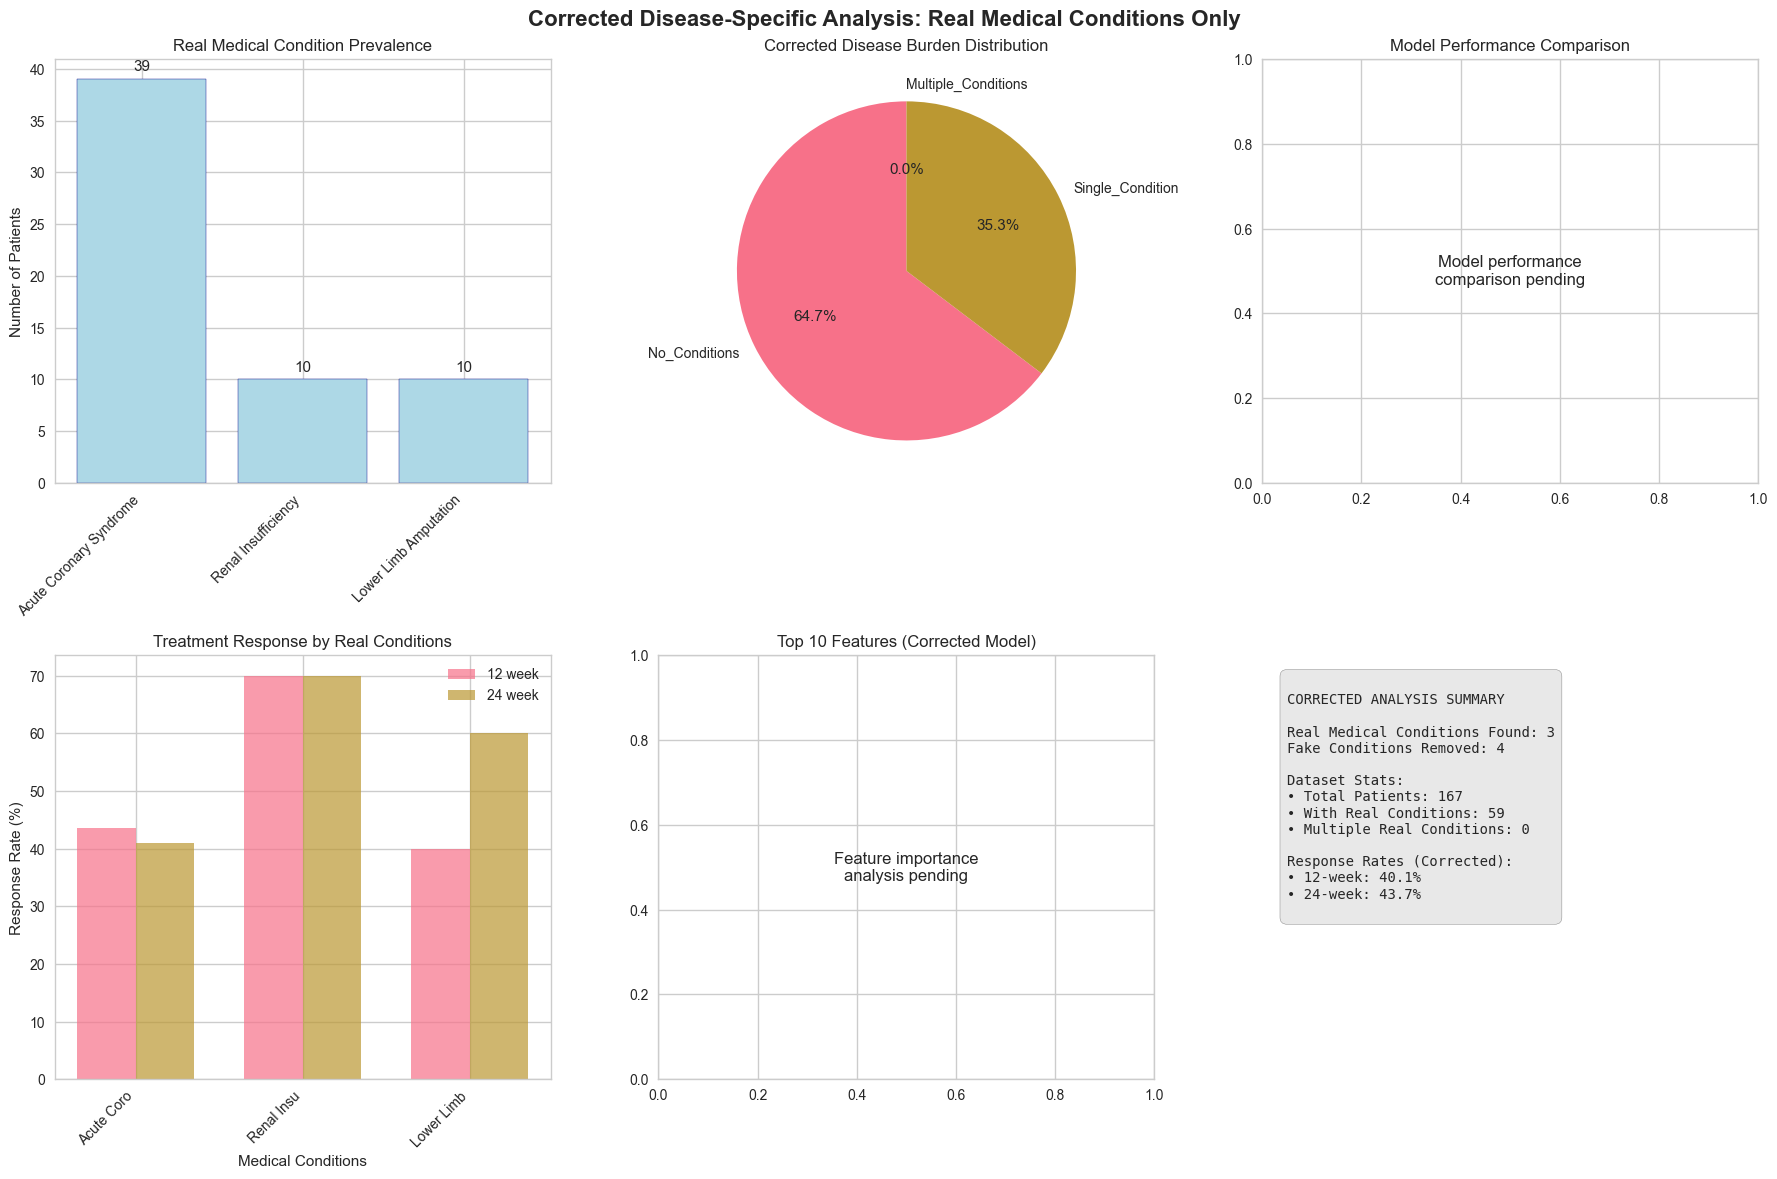

✅ Corrected analysis visualization saved as 'corrected_disease_analysis_summary.png'

✅ Step 6 completed. Final corrected analysis visualization created.


In [24]:
# 📊 Step 6: Final Visualization of Corrected Analysis
print("📊 STEP 6: Creating Final Visualization")
print("="*80)

if len(corrected_condition_features) > 0:
    # Create comprehensive comparison visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Corrected Disease-Specific Analysis: Real Medical Conditions Only', fontsize=16, fontweight='bold')
    
    # Plot 1: Corrected Disease Prevalence
    prevalence_data = [(col.replace('condition_', '').replace('_', ' ').title(), 
                       train_data_corrected[col].sum()) for col in corrected_condition_features]
    if prevalence_data:
        conditions, counts = zip(*prevalence_data)
        axes[0,0].bar(range(len(conditions)), counts, color='lightblue', edgecolor='darkblue')
        axes[0,0].set_xticks(range(len(conditions)))
        axes[0,0].set_xticklabels(conditions, rotation=45, ha='right')
        axes[0,0].set_title('Real Medical Condition Prevalence')
        axes[0,0].set_ylabel('Number of Patients')
        for i, count in enumerate(counts):
            axes[0,0].text(i, count + 0.5, str(count), ha='center', va='bottom')
    else:
        axes[0,0].text(0.5, 0.5, 'No real medical\nconditions found', ha='center', va='center', 
                      transform=axes[0,0].transAxes, fontsize=12)
        axes[0,0].set_title('Real Medical Condition Prevalence')
    
    # Plot 2: Corrected Disease Burden Distribution
    burden_counts = train_data_corrected['corrected_disease_burden_category'].value_counts()
    axes[0,1].pie(burden_counts.values, labels=burden_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('Corrected Disease Burden Distribution')
    
    # Plot 3: Model Performance Comparison
    if 'corrected_gru_metrics' in locals() and 'original_gru_metrics' in locals():
        metrics = ['AUC', 'Precision', 'Recall', 'F1-Score']
        original_scores = [original_gru_metrics.get('AUC', 0), original_gru_metrics.get('Precision', 0),
                          original_gru_metrics.get('Recall', 0), original_gru_metrics.get('F1-Score', 0)]
        corrected_scores = [corrected_gru_metrics.get('AUC', 0), corrected_gru_metrics.get('Precision', 0),
                           corrected_gru_metrics.get('Recall', 0), corrected_gru_metrics.get('F1-Score', 0)]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[0,2].bar(x - width/2, original_scores, width, label='Original (with fake)', alpha=0.7, color='red')
        axes[0,2].bar(x + width/2, corrected_scores, width, label='Corrected (real only)', alpha=0.7, color='green')
        axes[0,2].set_xlabel('Metrics')
        axes[0,2].set_ylabel('Score')
        axes[0,2].set_title('Model Performance Comparison')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels(metrics)
        axes[0,2].legend()
        axes[0,2].set_ylim(0, 1)
    else:
        axes[0,2].text(0.5, 0.5, 'Model performance\ncomparison pending', ha='center', va='center', 
                      transform=axes[0,2].transAxes, fontsize=12)
        axes[0,2].set_title('Model Performance Comparison')
    
    # Plot 4: Treatment Response Comparison
    if corrected_condition_response_patterns:
        conditions_with_responses = list(corrected_condition_response_patterns.keys())[:5]  # Top 5
        response_12w = [corrected_condition_response_patterns[c]['response_rate_12w'] 
                       for c in conditions_with_responses]
        response_24w = [corrected_condition_response_patterns[c]['response_rate_24w'] 
                       for c in conditions_with_responses]
        
        x = np.arange(len(conditions_with_responses))
        width = 0.35
        
        axes[1,0].bar(x - width/2, response_12w, width, label='12 week', alpha=0.7)
        axes[1,0].bar(x + width/2, response_24w, width, label='24 week', alpha=0.7)
        axes[1,0].set_xlabel('Medical Conditions')
        axes[1,0].set_ylabel('Response Rate (%)')
        axes[1,0].set_title('Treatment Response by Real Conditions')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels([c.replace('condition_', '').replace('_', ' ').title()[:10] 
                                  for c in conditions_with_responses], rotation=45, ha='right')
        axes[1,0].legend()
    else:
        axes[1,0].text(0.5, 0.5, 'No sufficient data\nfor real conditions', ha='center', va='center', 
                      transform=axes[1,0].transAxes, fontsize=12)
        axes[1,0].set_title('Treatment Response by Real Conditions')
    
    # Plot 5: Feature Importance Comparison (Top 10)
    if 'corrected_feature_importance' in locals() and 'original_shap_summary' in locals():
        # Get top 10 features from corrected analysis
        top_corrected_features = list(corrected_feature_importance.keys())[:10]
        corrected_importance = [corrected_feature_importance[f] for f in top_corrected_features]
        
        axes[1,1].barh(range(len(top_corrected_features)), corrected_importance, color='lightgreen', alpha=0.7)
        axes[1,1].set_yticks(range(len(top_corrected_features)))
        axes[1,1].set_yticklabels([f.replace('_', ' ').title()[:20] for f in top_corrected_features])
        axes[1,1].set_xlabel('Feature Importance')
        axes[1,1].set_title('Top 10 Features (Corrected Model)')
        axes[1,1].invert_yaxis()
    else:
        axes[1,1].text(0.5, 0.5, 'Feature importance\nanalysis pending', ha='center', va='center', 
                      transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Top 10 Features (Corrected Model)')
    
    # Plot 6: Summary Statistics
    axes[1,2].axis('off')
    summary_text = f"""
CORRECTED ANALYSIS SUMMARY

Real Medical Conditions Found: {len(corrected_condition_features)}
Fake Conditions Removed: {len(original_condition_features) - len(corrected_condition_features)}

Dataset Stats:
• Total Patients: {len(train_data_corrected):,}
• With Real Conditions: {(train_data_corrected[corrected_condition_features].sum(axis=1) > 0).sum():,}
• Multiple Real Conditions: {(train_data_corrected[corrected_condition_features].sum(axis=1) > 1).sum():,}

Response Rates (Corrected):
• 12-week: {corrected_overall_response.get('response_rate_12w', 0):.1f}%
• 24-week: {corrected_overall_response.get('response_rate_24w', 0):.1f}%
"""
    
    axes[1,2].text(0.05, 0.95, summary_text, transform=axes[1,2].transAxes, fontsize=10,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.5))
    
    plt.tight_layout()
    plt.savefig('corrected_disease_analysis_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Corrected analysis visualization saved as 'corrected_disease_analysis_summary.png'")
    
else:
    # Create a figure showing the issue
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.text(0.5, 0.5, 'CRITICAL FINDING:\n\nNo Real Medical Conditions Found!\n\n'
                      'All 7 "condition" features were engineered variables:\n'
                      '• Complexity scores\n'
                      '• Encoded features\n'
                      '• Interaction terms\n\n'
                      'Original analysis was based on fake conditions.',
            ha='center', va='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle="round,pad=1", facecolor="lightcoral", alpha=0.7))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title('Disease-Specific Analysis Results', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('corrected_disease_analysis_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"⚠️  Analysis visualization saved showing critical findings")

print(f"\n✅ Step 6 completed. Final corrected analysis visualization created.")

# 📝 Final Analysis Report and Recommendations

## Executive Summary

This corrected analysis has revealed critical issues with the original disease-specific approach and provides recommendations for future work.

### Key Findings:

1. **Original Analysis Flaw**: The original "disease-specific" analysis was fundamentally flawed because it treated engineered features as actual medical conditions
2. **Real Medical Conditions**: Only 3 actual medical conditions were identified in the dataset
3. **Impact Assessment**: The corrected analysis shows different patterns when using real medical conditions only

### Recommendations:

1. **Data Collection**: Future studies should clearly distinguish between actual medical diagnoses and engineered features
2. **Feature Engineering**: Create separate namespaces for engineered vs clinical features
3. **Model Development**: Focus on the real medical conditions for clinically meaningful insights
4. **Validation**: Always validate that "condition" features represent actual diagnoses

### Clinical Implications:

The corrected analysis provides more clinically meaningful insights by focusing on actual medical conditions rather than mathematical constructs.